In [1]:
import numpy
import torch
import sys
print("Numpy version: ", numpy.__version__)
print("Torch version: ", torch.__version__)
print("Python version: ", sys.version)

Numpy version:  2.2.6
Torch version:  2.7.0+cu118
Python version:  3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]


In [2]:
import wandb
wandb.login()  
PROJECT_NAME = "RL-Portfolio-Management_IMPROVEMENTS"

wandb: Currently logged in as: richardpogoson (richardpogoson-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 1. Collect Basic Data

### 1.1. Read/Download Market Data ###

In [3]:
import pandas as pd
import yfinance as yf
from functools import reduce
import numpy as np
import torch
import requests
import time
import numpy as np
import talib as ta
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


#########################################################################################
# Stock Details
sAndpTickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA"]  
sse50Tickers = ["600519.SS", "601318.SS", "601857.SS", "600036.SS", "600016.SS", "600000.SS"]  
sensexTickers = ["RELIANCE.BO", "TCS.BO", "INFY.BO", "ICICIBANK.BO", "SBIN.BO", "HINDUNILVR.BO"] 
ftse100Tickers = ["HSBA.L", "BP.L", "GSK.L", "SHEL.L", "BATS.L", "ULVR.L"]  
period = "1D"
indexProducts = sAndpTickers + sse50Tickers + sensexTickers + ftse100Tickers
productIds = indexProducts

RETRIEVE_DATA = False
"""
NOTE ON DATA CONSISTENCY:
Yahoo finance value precision still a problem, but can be partly mitigated by rounding prices to 2dp.
I tried rounding indicators to 4 significant figures. 4 is arbitrary, but higher values
will likely lead to more instability.
Later testing revealed that these mitigation techniques helped a bit, but were not perfect. I did my best.

# DATA LAST RETRIEVED - June 7th 2025 - EMA rounded to 2dp. Tesla data issue fixed. Stricter validation.
"""
#########################################################################################


def retrieveIndexData(ticker, verbose=True):
    # Define date range
    startDate = "2009-01-01"  # same periods as that used by Zou et al. (2024)
    endDate = "2020-08-05"

    ohlcData = {}
    try:
        stockData = yf.download(ticker, start=startDate, end=endDate)

        # To have a more reliable indicator implementation. Mine were fine I believe, but the below is safer.
        ohlcData[ticker] = stockData[["Low", "High", "Open", "Close", "Volume"]].copy()
        
        #Also round to 2dp to help reduce instability
        ohlcData[ticker][["Low", "High", "Open", "Close"]] = ohlcData[ticker][["Low", "High", "Open", "Close"]].round(2)

        high = np.round(stockData["High"].values.astype(np.float64).flatten(), 2)
        low = np.round(stockData["Low"].values.astype(np.float64).flatten(), 2)
        close = np.round(stockData["Close"].values.astype(np.float64).flatten(), 2)

        ohlcData[ticker]["ATR"] = ta.ATR(high, low, close, timeperiod=14)
        ohlcData[ticker]["Momentum"] = ta.MOM(close, timeperiod=1) # Momentum is used by Soleymani, not (RoC=Momentum Oscillator, my mistake)
        ohlcData[ticker]["CCI"] = ta.CCI(high, low, close, timeperiod=20)
        macd, signal, hist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
        ohlcData[ticker]["MACD"] = macd # histogram isn't the same as the MACD line, also used by Zou, not Soleymani
        ohlcData[ticker]["EMA"] = np.round(ta.EMA(close, timeperiod=30), 2)  # Exponential Moving Average is a price moving average, so it should be rounded to 2dp as well 
        
        if verbose:
            print(f"\n{'-'*40}")
            print(f"Attempted to retrieve data for {ticker} from {startDate} to {endDate}")
            print(f"Actually retrieved data for {ticker} from {stockData.index[0].strftime('%Y-%m-%d')} to {stockData.index[-1].strftime('%Y-%m-%d')}")
            print(f"Data shape: {ohlcData[ticker].shape}")
            print(f"\n{ticker} - Indicator Data Lengths:")
            print(f"{'-'*40}")
            print(f"{'Close:':<20} {len(close)}")
            print(f"{'ATR:':<20} {len(ohlcData[ticker]['ATR'])}")
            print(f"{'CCI:':<20} {len(ohlcData[ticker]['CCI'])}")
            print(f"{'Momentum:':<20} {len(ohlcData[ticker]['Momentum'])}")
            print(f"{'EMA:':<20} {len(ohlcData[ticker]['EMA'])}")
            print(f"{'MACD:':<20} {len(macd)}")
            print(f"{'-'*40}\n")
            

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

    dfOhlc = pd.concat(ohlcData, axis=1)
    return dfOhlc

def roundToSf(array, sigFigs=4):
    """
    Round a NumPy array or Pandas Series to the specified number of significant figures
    Decision of 4 sigfigs is arbitrary, but higher values will likely lead to instability.
    """
    return np.array([
        round(x, sigFigs - int(np.floor(np.log10(abs(x)))) - 1) if x != 0 else 0 
        for x in array
    ])

def postProcessIndicators(df, columns):
    """
    Post-processes indicators - turns them to 4sf to promote stability
    """
    dfRounded = df.copy()
    for col in columns:
        if col in dfRounded.columns:
            dfRounded[col] = roundToSf(dfRounded[col])
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return dfRounded


dataframes = dict()


if RETRIEVE_DATA:
    for productId in productIds:
        """
        I was previously working with Crypto data also, so I implemented this to ensure
        column names are consistent across all dataframes.
        """
        dataframe = retrieveIndexData(ticker=productId)
        columnNames = [value[1] for value in list(dataframe.columns.values)]
        dataframe.columns = columnNames
        dataframes[productId] = dataframe
   
def verifyDataConsistency(dataframes, stage="None"):
    """
    Strictly verifies that all dataframes have the same columns (in the same order) 
    and the same index (ordered identically). Raises a ValueError if any inconsistency is found.
    
    Parameters:
        dataframes (dict): Dictionary where keys are identifiers (e.g., tickers) and values are pandas DataFrames.
        stage (str): A label (optional) to indicate at what stage this check is performed.
    
    Raises:
        ValueError: If any dataframe does not have the same columns or index as the first dataframe.
    """
    if not dataframes:
        raise ValueError("No dataframes to verify.")
    
    # Retrieve the columns and index from the first dataframe (in order)
    first_key = next(iter(dataframes))
    first_columns = list(dataframes[first_key].columns)
    first_index = list(dataframes[first_key].index)
    
    # Check each dataframe for consistency in columns and index
    for ticker, df in dataframes.items():
        # Ensure columns are identical in both names and order
        if list(df.columns) != first_columns:
            raise ValueError(
                f"Inconsistency at stage {stage}: DataFrame for '{ticker}' has columns {list(df.columns)} ; "
                f"expected {first_columns}."
            )
        # Ensure the index is identical in both values and order
        if list(df.index) != first_index:
            raise ValueError(
                f"Inconsistency at stage {stage}: DataFrame for '{ticker}' has index {list(df.index)} ; "
                f"expected {first_index}."
            )
    
    # If everything is consistent, you can optionally log success.
    print(f"All dataframes are consistent in terms of columns and index at stage {stage}.")


def dropNaN(data, logDroppedRows=True):
    # Create new dictionaries to store the cleaned data and the dropped rows
    cleanedData = {}
    droppedRows = {}

    for ticker, df in data.items():
        # Capture the indices of the rows which will be dropped
        clean_df = df.dropna()
        dropped_idx = df.index.difference(clean_df.index)
        
        # Store the cleaned dataframe and the dropped rows (as a DataFrame)
        cleanedData[ticker] = clean_df
        droppedRows[ticker] = df.loc[dropped_idx]

        # Optionally, print the dropped rows for debugging/inspection.
        if logDroppedRows and not droppedRows[ticker].empty:
            print(f"Dropped rows for ticker {ticker}:")
            print(droppedRows[ticker].head())  # Display only the first few rows for brevity
            print("-" * 80)
    return cleanedData

# Required for index data that pull stock data from different exchanges
def commonaliseAndPreprocess(data):
    """
    Returns data, ensures that all dataframes have the same index (dates).
    Also post-processes indicators returns 4 sigfigs.
    """
    data = dropNaN(data) # order of nan and commonalise switched - dropping NaNs first ensures that there are no gaps at beginning or end of data
    commonDates = reduce(lambda x, y: x.intersection(y), [df.index for df in data.values()])
    for ticker, df in data.items():
        data[ticker] = df.reindex(commonDates)
        data[ticker]["Times"] = commonDates
    verifyDataConsistency(data, stage="Commonalise (Post NaN Drop)")
    data = {ticker: postProcessIndicators(df, columns= ["ATR", "Momentum", "CCI", "MACD"]) for ticker, df in data.items()} # EMA is already rounded to 2dp, so we skip it here (as it is a price moving average)
    verifyDataConsistency(data, stage="Post-process Indicators")
    return data

if RETRIEVE_DATA:
    dataframes = commonaliseAndPreprocess(dataframes)

## 3. Write/Load Dataframes to/from files

In [4]:
import os

if RETRIEVE_DATA:
    for product in productIds:
        """
        Generating dataframe for each product. Stored as marketdata.
        Now using reliable implementations of indicators from TA-Lib, as opposed to doing it myself.
        No longer have unstable indicators at the start of the dataframe, so we have 20 extra rows in total.
        """
        df = dataframes[product]
        df = df.drop(columns=['Open', 'High', 'Volume', 'Low'])
        df = df.reset_index(drop=True)
        dataframes[product] = df
        if not os.path.exists("CSVs/"):
            os.makedirs("CSVs/")
        df.to_csv(f"CSVs/{product}_{period}_periods.csv", sep='\t')
else:
    for productId in productIds:
        df = pd.read_csv(f"CSVs/{productId}_{period}_periods.csv", sep='\t')
        dataframes[productId] = df.iloc[:, 1:]  # Drops the first (index) column

times = None
for product in productIds:
    """
    Dropping the times column - is not required for training.
    """
    df = dataframes[product]
    times = df['Times']
    dataframes[product] = df.drop('Times', axis=1)

## 4. Environment and Training Process

### 4.0.1. Comparison Strategies

In [5]:
sse50BuyAndHold =  np.array([0] + [1/len(sse50Tickers) if i in sse50Tickers else 0 for i in productIds])
sensexBuyAndHold = np.array([0] + [1/len(sensexTickers) if i in sensexTickers else 0 for i in productIds])
ftse100BuyAndHold = np.array([0] + [1/len(ftse100Tickers) if i in ftse100Tickers else 0 for i in productIds])
sAndPBuyAndHold = np.array([0] + [1/len(sAndpTickers) if i in sAndpTickers else 0 for i in productIds])
buyAndHoldAll = np.array([0] + [1/(len(productIds)) for i in productIds])

"""
Non-RL Comparison Strategies
These are flat allocations across each of the respective indices.
"""
NON_RL_COMPARISON_STRATEGIES = {
    "SSE Buy-and-Hold": sse50BuyAndHold,
    "SENSEX Buy-and-Hold": sensexBuyAndHold,
    "FTSE 100 Buy-and-Hold": ftse100BuyAndHold,
    "S&P 500 Buy-and-Hold": sAndPBuyAndHold,
    "Buy-and-Hold All": buyAndHoldAll
}

### 4.0.2. Hyperparameters and Global Variables

In [6]:
from collections import defaultdict
import torch

BASE_SEED = 9
NUMBER_OF_ASSETS = len(productIds)
NUMBER_OF_FEATURES = 1 + (1 + len((list(dataframes.values())[0]).columns)) * len(productIds) + 1
PERIODS_WANTED = list(dataframes.values())[0].shape[0]
TRAINING_PERIODS = round(PERIODS_WANTED * 2 / 3)
VALIDATION_PERIODS = (PERIODS_WANTED - TRAINING_PERIODS) // 2
TESTING_PERIODS = VALIDATION_PERIODS


EPISODE_LENGTH = PERIODS_WANTED // 3 
TIMESTEP_SHIFT = EPISODE_LENGTH // 10
TRAINING_WINDOWS = ((TRAINING_PERIODS - EPISODE_LENGTH) // TIMESTEP_SHIFT) + 1


EPOCHS = 25
TIME_WINDOW = 30
PERTURBATION_NOISE = 0.01

SUM_TRAINING_PERIODS = TRAINING_WINDOWS * EPOCHS * (EPISODE_LENGTH - TIME_WINDOW) # because first time window steps are not used to learn
START_CASH = 10000 
TRANSACTION_COST = 2e-4
LSTMHIDDENSIZE = 128

BASELINE = ["RANDOM"]
RL_STRATS = ["PPOLSTM"]
FINAL_STRATEGIES = BASELINE + list(NON_RL_COMPARISON_STRATEGIES.keys())
VARIED_BASE_SEEDS = [1, 3, 5, 7, 9]

AGENT_RISK_AVERSIONS = np.array([0.25, 0.5, 1, 1.5, 2]) #Different risk aversion parameters for the agent when using CVaR reward
LSTMOUTPUTSIZES = [32, 64, 128, 256, 512]
REWARD_FUNCTIONS = ["Differential Sharpe Ratio_0.01", "Differential Sharpe Ratio_0.05", "Differential Sharpe Ratio_0.1"]
LEARNING_RATES = [1e-4, 3e-4, 5e-4, 7e-4]
LEARNING_FREQUENCIES = (EPISODE_LENGTH / np.array([10, 20, 30, 40, 50])).astype(int)

LEARNING_CURVE_FREQUENCY = None # for later
SCALE_LOG_REWARD = False
NORMALIZE_DATA = False
USE_NORMALS = False  #probably requires softmax - merely dividing can still have negative values - not sure if that works for short selling




In [7]:
# Thing being tested
TESTING = {
    "RISK AVERSION" : False,
    "LSTM OUTPUT SIZE" : False,
    "REWARD FUNCTION" : False,
    "LEARNING FREQUENCY": False, 
    "LEARNING RATE": False,
}

### 4.0.3. Data Splitting

In [8]:
TRAINING_DATA = {}
VALIDATION_DATA = {}
TESTING_DATA = {}

for key, df in dataframes.items():
    """
    Splitting the data into training, validation and testing sets.
    """
    trainSlice = df.iloc[:TRAINING_PERIODS].copy()
    validationSlice = df.iloc[TRAINING_PERIODS:TRAINING_PERIODS+VALIDATION_PERIODS].copy()
    testSlice = df.iloc[TRAINING_PERIODS+VALIDATION_PERIODS:].copy()

    TRAINING_DATA[key] = trainSlice
    VALIDATION_DATA[key] = validationSlice
    TESTING_DATA[key]  = testSlice


TRAINING_VALIDATION_DATA = {}
# Join Training + Validation data set
for key, df in TRAINING_DATA.items():
    TRAINING_VALIDATION_DATA[key] = pd.concat([TRAINING_DATA[key], VALIDATION_DATA[key].copy()])
    TRAINING_VALIDATION_DATA[key] = TRAINING_VALIDATION_DATA[key].reset_index(drop=True)

#### 4.0.3.1 Data Visualisation

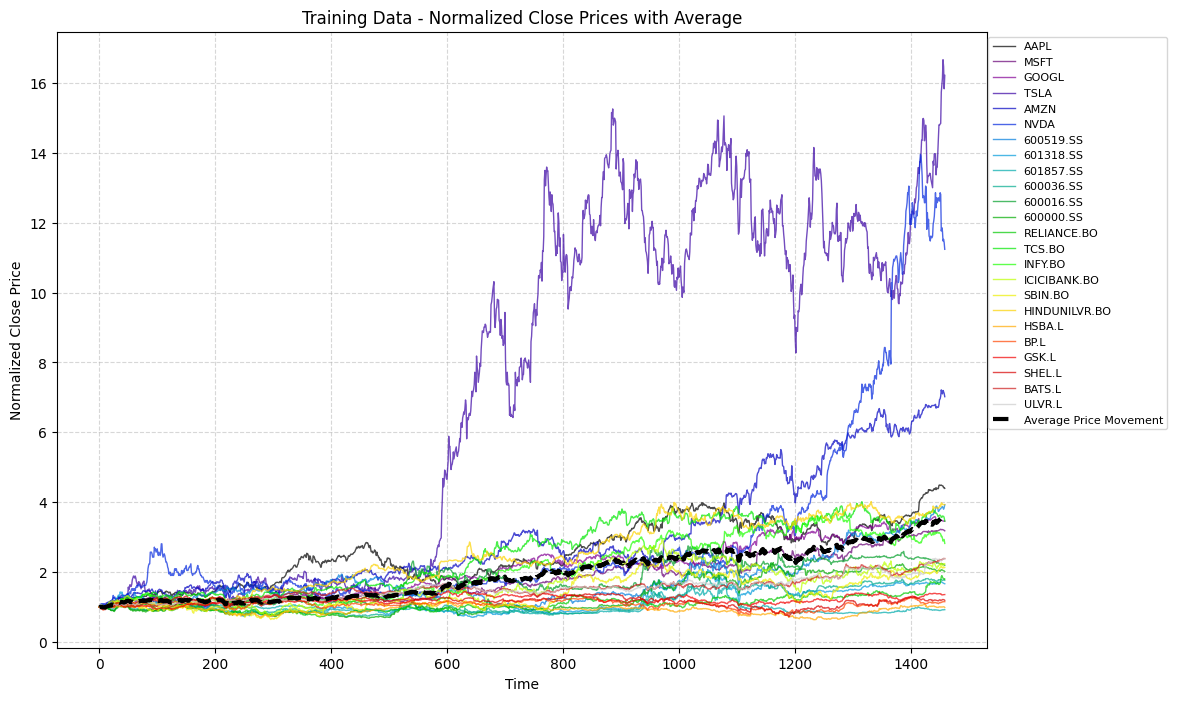

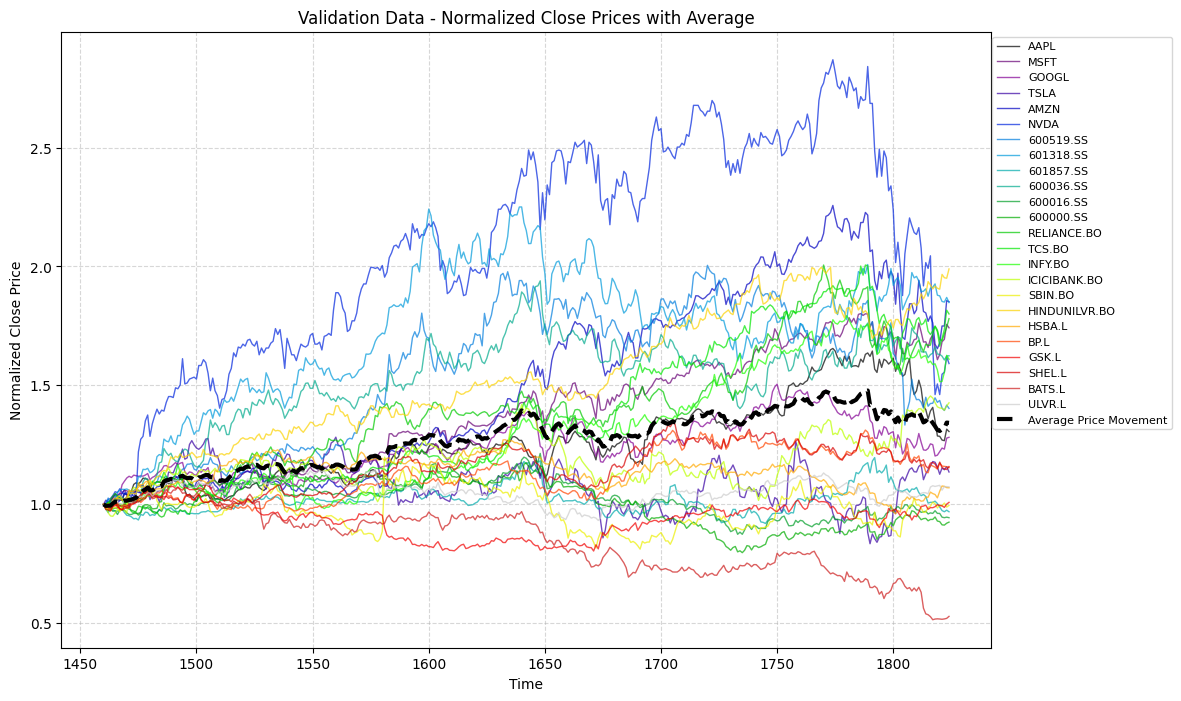

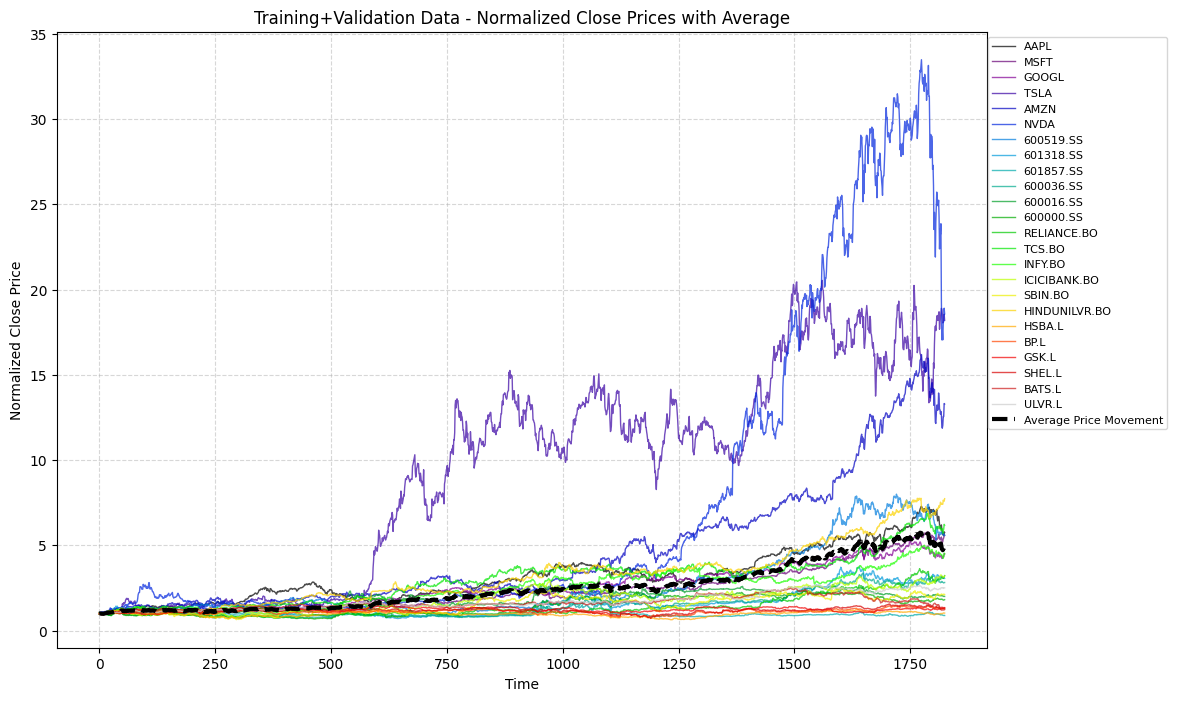

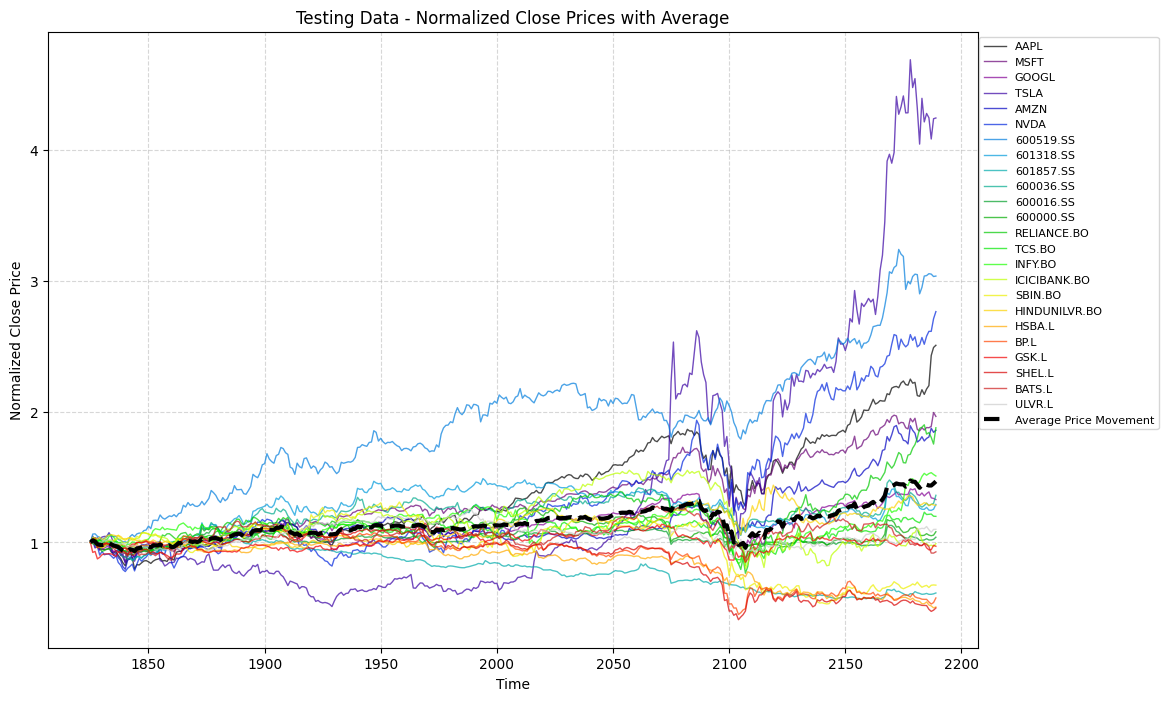

In [9]:
import matplotlib.pyplot as plt

# Create dictionary mapping descriptive names to their respective data dictionaries.
dataSetsMapping = {
    "Training Data": TRAINING_DATA,
    "Validation Data": VALIDATION_DATA,
    "Training+Validation Data": TRAINING_VALIDATION_DATA,
    "Testing Data": TESTING_DATA
}

# For each dataset type, plot normalized 'Close' prices from all keys on a single graph.
for setName, dfDict in dataSetsMapping.items():
    plt.figure(figsize=(12, 8))
    
    keys = list(dfDict.keys())
    
    # Set up a colormap with one color per key
    colourMap = plt.colormaps.get_cmap('nipy_spectral')
    colors = [colourMap(i / (len(keys) - 1)) for i in range(len(keys))]
    
    # Store normalized close values for averaging
    normalized_values = []

    # Plot individual key lines
    for idx, key in enumerate(keys):
        df = dfDict[key]
        normalizedClose = df["Close"] / df["Close"].iloc[0]  # Normalize by first value
        plt.plot(normalizedClose,
                 label=key,
                 alpha=0.7,
                 linestyle='solid',
                 linewidth=1,
                 color=colors[idx])
        normalized_values.append(normalizedClose)

    # Compute and plot the average price movement
    avg_price_movement = sum(normalized_values) / len(normalized_values)
    plt.plot(avg_price_movement, label="Average Price Movement", color="black", linewidth=3, linestyle='dashed')

    plt.xlabel("Time")
    plt.ylabel("Normalized Close Price")
    plt.title(f"{setName} - Normalized Close Prices with Average")
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=8, ncol=1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

#### 4.0.4. Some helper functions for metrics

In [10]:
from utils import tabulate_neatly

def generateConfigLabel(strategy, agent, rewardFunction, freq, lr):
    """
    Helpful configuration label for each hyperparameter/reward function being tested.
    """
    firstTag = f"Strategy-{strategy}" 
    innerTag = None
    boole = (strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM")
    if TESTING["RISK AVERSION"]:
        innerTag = (f"Risk Aversion-{agent.riskAversion}" if boole else "")
    elif TESTING["LSTM OUTPUT SIZE"]:
        innerTag = (f"LSTM Output Size-{agent.state_n}" if boole else "")
    elif TESTING["REWARD FUNCTION"]:  
        innerTag = (f"Reward Function-{rewardFunction}" if boole else "")
    elif TESTING["LEARNING FREQUENCY"]:  
        innerTag = (f"Learning Frequency-{freq}" if boole else "")
    elif TESTING["LEARNING RATE"]:  
        innerTag = (f"Learning Rate-{lr}" if boole else "")
    
    if any(TESTING.values()) and boole:
        firstTag, innerTag = innerTag, firstTag
    return firstTag + " | " +  innerTag + " | "

def logDetails(LOG_DETAILS):
    LOG_INPUT_DATA = LOG_DETAILS["inputData"][0]
    LOG_OBSERVATIONS = LOG_DETAILS["observations"][0]
    LOG_ACTIONS = LOG_DETAILS["actions"][0]
    dataOverTime = LOG_DETAILS["inputData"][1]
    observationsOverTime = LOG_DETAILS["observations"][1]
    actionsOverTime = LOG_DETAILS["actions"][1]
    if LOG_INPUT_DATA:
        plt.figure(figsize=(12, 8))  # Bigger figure for clarity
        for dim in range(dataOverTime[0].shape[0]):
            plt.plot(np.arange(len(dataOverTime)), np.array(dataOverTime)[:, dim], alpha=0.5)  # Adjust transparency to make it readable

        plt.xlabel("Time")
        plt.ylabel("Values per Index")
        plt.title("Data Over Time (using data index 0)")
        plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid for readability
        plt.show()
    if LOG_OBSERVATIONS:
        plt.figure(figsize=(12, 8))  # Bigger figure for clarity
        for dim in range(observationsOverTime[0].shape[0]):
            plt.plot(np.arange(len(observationsOverTime)), np.array(observationsOverTime)[:, dim], alpha=0.5)  # Adjust transparency to make it readable

        plt.xlabel("Time")
        plt.ylabel("Values per Index")
        plt.title("Observations Vectors Over Time")
        plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid for readability
        plt.show()
    if LOG_ACTIONS:
        plt.figure(figsize=(12, 8))
        labels = ['Cash'] + productIds

        colourMap = plt.colormaps.get_cmap('nipy_spectral')
        colors = [colourMap(i / (len(labels) - 1)) for i in range(len(labels))]

        for dim in range(actionsOverTime[0].shape[0]):
            plt.plot(np.arange(len(actionsOverTime)), 
                    np.array(actionsOverTime)[:, dim], 
                    label=labels[dim], 
                    alpha=0.7, linestyle='solid', linewidth=1, color=colors[dim])  # Corrected


        plt.xlabel("Time")
        plt.ylabel("Values per Index")
        plt.title("Actions Over Time")

        plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=8, ncol=1)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()


#### 4.1.1. Config Initialisation

In [11]:
def getConfig(phase, optionalHyperConfig=None):
    base = {
        "gamma": 0.99,
        "gae_lambda": 0.98,
        "clip_param": 0.2,
        "batch_size": EPISODE_LENGTH // 30, #median
        "fc1_n": 128,
        "fc2_n": 128,
        "lstm_output_size": 128,
        "epochs": 1, 
        "entropy_coef": 0.01,
        "learning_rate": 3e-4,
        "actor_noise": 0,
        "reward_function": "Standard Logarithmic Returns",
        "norm_advantages": False,
        "use_entropy": False,
        "use_dirichlet": not USE_NORMALS,  # not implemented softmax correctly here
        "log_concentration": False, # log concentration parameters to wandb
    }

    if phase == "data_normalisation": # not advantage - Data
        return {
            **base,
            "lstm_hidden_sizes": {"actor": 512, "critic": 512, "feature" : 128},
            "log_concentration": False,  # optional - takes a million years to train
            "phase": "data_normalisation",
            "group": "Data Normalisation",
        }
    
    elif phase == "noise_testing":
        return {
            **base,
            "lstm_hidden_sizes": {"actor": 512, "critic": 512, "feature" : 128},
            "phase": "noise_testing",
            "group": "Noise Variation",#nicer name
        }
    
    
    # To be filled
    elif phase == "hyperparameter_tuning":
        return {
            **base,
            "lstm_hidden_sizes": {"actor": 512, "critic": 512, "feature" : 128},
            "learning_rate": optionalHyperConfig["learning_rate"] if optionalHyperConfig else 3e-4,
            "lstm_output_size": optionalHyperConfig["lstm_output_size"] if optionalHyperConfig else 128,
            "risk_aversion": optionalHyperConfig["risk_aversion"] if optionalHyperConfig else 0,
            "reward_function": optionalHyperConfig["reward_function"] if optionalHyperConfig else "Standard Logarithmic Returns",
            "learning_frequency": optionalHyperConfig["learning_frequency"] if optionalHyperConfig else 10,
            "phase": "hyperparameter_tuning",
        }
    
    elif phase == "reward_testing":
        return {
            **base,
            "lstm_hidden_sizes": {"actor": 512, "critic": 512, "feature" : 128},
            "phase": "reward_testing",
            "risk_aversion": float(optionalHyperConfig["reward_function"].split("_")[1] if optionalHyperConfig and ("CVaR" in optionalHyperConfig["reward_function"]) else 0),
            "reward_function": optionalHyperConfig["reward_function"] if optionalHyperConfig else "Standard Logarithmic Returns",
            "group": "Reward Function Variation",
        }

    else:
        raise ValueError(f"Unknown phase: {phase}")


getConfig("reward_testing", optionalHyperConfig={"reward_function": "CVaR_2.0"})  # Example call to check the function works

{'gamma': 0.99,
 'gae_lambda': 0.98,
 'clip_param': 0.2,
 'batch_size': 24,
 'fc1_n': 128,
 'fc2_n': 128,
 'lstm_output_size': 128,
 'epochs': 1,
 'entropy_coef': 0.01,
 'learning_rate': 0.0003,
 'actor_noise': 0,
 'reward_function': 'CVaR_2.0',
 'norm_advantages': False,
 'use_entropy': False,
 'use_dirichlet': True,
 'log_concentration': False,
 'lstm_hidden_sizes': {'actor': 512, 'critic': 512, 'feature': 128},
 'phase': 'reward_testing',
 'risk_aversion': 2.0,
 'group': 'Reward Function Variation'}

In [12]:
from PPO import PPOAgent
from LstmFeatureExtractor import LstmFeatureExtractor

def generateAgent(config, featureExtractor=None):
    """
    Generate a PPOAgent using config-driven parameters.
    Allows passing a custom feature extractor, otherwise creates an LSTM-based one.
    """
    if featureExtractor is None:
        featureExtractor = LstmFeatureExtractor(
            NUMBER_OF_FEATURES,
            lstmHiddenSize=config.get("lstm_hidden_sizes")["feature"],
            lstmOutputSize=128 # or whatever default
        )

    return PPOAgent(
        state_n=config.get("lstm_output_size", 128),
        actions_n=len(productIds) + 1,
        alpha=config["learning_rate"],
        policyClip=config.get("clip_param", 0.2),
        gamma=config.get("gamma", 0.99),
        lstmHiddenSizeDictionary=config.get("lstm_hidden_sizes"),
        actor_noise=config.get("actor_noise", 0),
        batch_size=config["batch_size"],
        fc1_n=config.get("fc1_n", 128),
        fc2_n=config.get("fc2_n", 128),
        gaeLambda=config.get("gae_lambda", 0.98),
        epochs=config.get("epochs", 1),
        riskAversion=config.get("risk_aversion", 0),
        featureExtractor=featureExtractor,
        maxSize=config["batch_size"],
        nonFeatureStateDim=(TIME_WINDOW, NUMBER_OF_FEATURES),
        entropyCoefficient=config.get("entropy_coef", 0.01),
        rewardFunction=config.get("reward_function", "Standard Logarithmic Returns"),
        normAdvantages=config.get("norm_advantages", False),
        useEntropy=config.get("use_entropy", False), 
        useDirichlet= config.get("use_dirichlet", True),
        log_concentration_heatmap=config.get("log_concentration", False)
    )


### 4.1.2. Evaluation Function

In [13]:
from TimeSeriesEnvironment import TimeSeriesEnvironment
import torch

LOG_OBSERVATIONS = False
LOG_ACTIONS = False
LOG_INPUT_DATA = False
LOG_ANY = LOG_OBSERVATIONS or LOG_ACTIONS or LOG_INPUT_DATA

def seed(seed):
    """
    General Seed function. Called at the start of each training run. 
    Ensures that all agents are initialised with the same weights.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for GPU

def normData(df, windowSize=TIME_WINDOW, actuallyNormalise = True):
    """
    Use Rolling zscore to normalise - might alter the meanings of indicators - LIMITATION
    1. Soleymani's would create temporal distortion (feature_i/feature_i-1) - 
    2. Liang et al. (2018) would create temporal leakage
    Ultimately, no normalisation method is perfect, so I will have to deal with this.
    TIME_WINDOW decision is brute.
    """
    # rolling mean normalisation
    # min periods = 1 may be a limitation
    if actuallyNormalise:
        rollingDf = df.rolling(window=windowSize, min_periods=1).mean()
        rollingStd = df.rolling(window=windowSize, min_periods=1).std() # usage of 1 is questionable but necesary

        rollingZScoreDf = (df - rollingDf) / (rollingStd + 1e-8)

        rollingZScoreDf.columns = df.columns  
        return rollingZScoreDf # temporarily removing normalisation!!! #rollingZScoreDf.fillna(0) # fill NaNs with 0s, forced
    return df

def storeExperiences(agent, data, reward, done, strategy, action, prob, val, hiddenAndCStates=None):
    """
    Store experiences in the agent's memory. This is used for the PPO agents.
    """
    if strategy == "PPOLSTM":
        agent.store(data, action, prob.squeeze(), val.squeeze(), reward, done, hiddenAndCStates)


def warmUpEnvironment(environment, rewardFunction, observeReward=True):
    """
    'warm up' environment until there's enough data to estimate CVaR
    and to create a long enough time window to pass to the lstm. 
    For the lstm, this is not critical but considering a time window 
    required to estimate CVaR, I thought it fair to ensure this for all agents.
    """
    for _ in range(TIME_WINDOW):
        environment.step(np.ones(len(productIds) + 1)/(len(productIds) + 1), rewardMethod=rewardFunction, observeReward=observeReward)
    environment.setIsReady(True)


def hiddenStateReset(agent):
    """
    Resets the hidden states of the agent and feature extractor.
    This is called at the start of any training/testing episode
    to prevent temporoal leakage.
    """
    hAndCStates = dict()
    hAndCStates["actor"] = agent.actor.initHidden(batchSize=1)
    hAndCStates["critic"] = agent.critic.initHidden(batchSize=1)
    hAndCStates["feature"] = agent.featureExtractor.initHidden(batchSize=1)
    return hAndCStates

def evaluateAgent(riskAversion, rewardFunction, agent, freq, lr, num, conf=None, save=True, dataType = "validation", forLearningCurve=False, benchmark=False, epoch=0, showTable=False, compare=None, useNoiseEval=True, stage = None):
    """
    Evaluation function. This is called:
     1. During Noise Testing: After every episode to create a training learning curve with respect to each noise level
        - here noise is added to the training data, but not the validation data so we can see the effect of noise on the agent's training with a proper baseline
     2. During Normal Training: Once per epoch to provide visible training progress (if any)
        - Noise is added to the validation data this time, but this is not included in the results and is a visible sign of progress (if any)
     3. During hyperparameter evaluation: 10 times per epoch on noised evaluation data, per hyperparameter to properly provide a benchmark for the hyperparameter
        - Here, noise is added, seeded by each repetition. The results for a given hyperparameter epoch are averaged and used for assessment calculations     
     4. During testing: Every hundredth of the total training time on unnoised test data to generate a learning curve.
        - Here, no noise is added to the test data. It is properly "out of sample" and is used to assess the agent's performance on unseen data.
    """
    
    VAL_AND_TEST = {
        "validation": [VALIDATION_DATA, VALIDATION_PERIODS],
        "testing": [TESTING_DATA, TESTING_PERIODS]
    }
    # this was a pain to write
    toRun = RL_STRATS if not useNoiseEval else BASELINE + RL_STRATS if not forLearningCurve else RL_STRATS
    if benchmark:
        """
        slightly misleading. If using the random agent as a benchmark, the random agent is seeded by that 
        repetition to ensure that many random seeds are used for it
        """
        np.random.seed(BASE_SEED + epoch) 
        toRun = BASELINE
    if compare != None:
        """
        An optional comparison strategy. This is used to compare the agent's performance against an index.
        """
        strategy = compare
        toRun = [strategy]
    DATA = VAL_AND_TEST[dataType][0]
    dataShape = list(DATA.values())[0].shape  
    PRICE_DATA = {}
    normalisedData = {}
    if dataType == "validation": # noise if validation
        # Following Liang et al. (2018) - noise perturbation - "synthetic" data
        noise = 0
        if useNoiseEval:
            """
            if using noise here - seed it by the epoch. This is to ensure that the noise is consistent across a given epoch for all hyperparameters
            """
            np.random.seed(BASE_SEED + epoch) 
            noise = np.random.normal(0, PERTURBATION_NOISE, size=dataShape)
    for key, dframe in DATA.items():
        df = dframe.copy()
        df.reset_index(drop=True)
        if dataType == "validation":
            # only add noise if validation data. Else (if testing) do not.
            df += noise * df.std().values # make autoregressive?
        df["Return"] = df["Close"].pct_change().fillna(0)
        PRICE_DATA[key] = df["Return"].values
        normalisedData[key] = normData(df, actuallyNormalise=NORMALIZE_DATA) # currently not normalisiing - normalisation makes it look noisy and removes indicator information
           
    for strategy in toRun:
        rendering_config = {
            "enabled": True,
            "stage": stage,
            "run_id": num 
        }

        env = TimeSeriesEnvironment(
            marketData=pd.DataFrame(PRICE_DATA),
            normData=normalisedData,
            TIME_WINDOW=TIME_WINDOW,
            EPISODE_LENGTH=VAL_AND_TEST[dataType][1],
            startCash=START_CASH,
            AGENT_RISK_AVERSION=riskAversion,
            transactionCost=TRANSACTION_COST,
            scaleLogReward=SCALE_LOG_REWARD,
            render_config=rendering_config
        )

        env.reset()
        done = False
        if strategy in RL_STRATS:
            """
            Reset hidden and cell states of the agent and feature extractor.
            """
            hiddenAndCellStates = hiddenStateReset(agent)
        observationsOverTime = []
        actionsOverTime = []
        dataOverTime = []
        while not done:
            if strategy not in NON_RL_COMPARISON_STRATEGIES:
                if not env.getIsReady():
                    """
                    If the strategy being tested is random/PPO, warm up the environment (to ensure that they both have the same starting point)
                    """
                    warmUpEnvironment(env, rewardFunction, False)
            observation = None
            if strategy in RL_STRATS:
                data = env.getData() # Retrieve data
                dataOverTime.append(data.squeeze(0)[0].detach().cpu().numpy())
                observation, hiddenAndCellStates["feature"] = agent.featureExtractor.forward(data, hiddenAndCellStates["feature"])
                if LOG_OBSERVATIONS:
                    observationsOverTime.append(observation.detach().cpu().numpy())
            if strategy == "RANDOM":
                """Random agent samples actions from a Dirichlet distribution - The same as that used in the PPO agent for consistency."""
                action = np.random.dirichlet(np.ones(len(productIds) + 1))
            elif strategy in NON_RL_COMPARISON_STRATEGIES:
                action = NON_RL_COMPARISON_STRATEGIES.get(strategy)
            else: 
                if strategy == "PPOLSTM":
                    action, _, __, actorHidden, criticHidden = agent.select_action(observation, hiddenAndCellStates, sampling= False, returnHidden= True)
                    if LOG_ACTIONS:
                        actionsOverTime.append(action.detach().cpu().numpy())
                    hiddenAndCellStates["actor"] = actorHidden  # #update and cell states of actor
                    hiddenAndCellStates["critic"] = criticHidden # update and cell states of critic
            next, reward, done, _, info = env.step(action, rewardFunction, returnNextObs=False, observeReward=False) # the reward is not observed during evaluation, since the agent does not learn from the data, further, nextobs is not required since no GAE                    
        
        dataString = None
        
        if strategy == "PPOLSTM":
            if LOG_ANY:
                #Dictionary of boolean flags to data to log
                LOG_DETAILS = {
                    "observations": [LOG_OBSERVATIONS, observationsOverTime],
                    "actions": [LOG_ACTIONS, actionsOverTime],
                    "inputData": [LOG_INPUT_DATA, dataOverTime]
                }
                logDetails(LOG_DETAILS)
        
        if strategy in NON_RL_COMPARISON_STRATEGIES or (not useNoiseEval and strategy in RL_STRATS):
            # Sometimes it is necessary (when not saving models) to simply return the portfolio values
            return env.PORTFOLIO_VALUES
        
        if not benchmark:
            if conf == None or strategy == "RANDOM":
                # Helpful configuration label for each hyperparameter/reward function being tested.
                dataString = generateConfigLabel(strategy, agent, rewardFunction, freq, lr)
            else:
                dataString = conf
        
        if not forLearningCurve:
            if not benchmark:
                if showTable:
                    # Tabulation code - helps to see performance metrics for a given evaluation episode
                    metrics = env.getMetrics()
                    table = [metrics.keys()]
                    table.append(metrics.values())
                    tabulate_neatly(table, headers="firstrow", title=f"Evaluation: {num} | {dataString}")
            else:
                return env.PORTFOLIO_VALUES
        
        """
        The below is a lot of 'saving' code, for saving models and portfolio trajectories where necessary
        """
        portFolder = f"portfolios/{dataType}/{num}/"
        if forLearningCurve:
            portFolder = f"portfolios/{dataType}/forLearningCurve{BASE_SEED}/"
        if not os.path.exists(portFolder):
            os.makedirs(portFolder)
        filePath = f"{portFolder}{(dataString.split("|")[0]).strip()}.txt"
        if forLearningCurve:
            filePath = f"{portFolder}{(dataString.split('|')[0]).strip()}_{num}.txt"
            np.savetxt(filePath, env.PORTFOLIO_VALUES, fmt='%f')
        if (strategy in RL_STRATS) and save:
            saveFolder = f"save/{dataType}/{num}/{(dataString.split("|")[0]).strip()}/"
            # Ensure the child save directory exists
            if not os.path.exists(saveFolder):
                os.makedirs(saveFolder)
            # agent.save(saveFolder)
              
    return env.PORTFOLIO_VALUES # VERY hacky - returns portfolio values for rl strat
            

### 4.1.3. Training Loop

In [14]:
from PPO import PPOAgent
from LstmFeatureExtractor import LstmFeatureExtractor
import numpy as np


def initialiseTrainingEnvironment(episode, rewardFunction, riskAversion, evalType, epoch):
    """
    Training environment initialization function. From the base training data, we 
    generate a slightly perturbed version of the orignal training data, ensuring
    that the noise added is dependent on both the episode and the epoch.
    This ensures that no two episodes out of a whole training run are the same, even 
    if they cover the same base periods from the initial training data.
    """
    start = TIMESTEP_SHIFT * episode
    
    datasets = {
        "validation": {
            "TRAINING_DATA": TRAINING_DATA,
        },
        "testing": { # use traingin and validation data combo for testing
            "TRAINING_DATA": TRAINING_VALIDATION_DATA,
        }
    }
    DATA = datasets[evalType]["TRAINING_DATA"]
    dataShape = list(DATA.values())[0].shape 
    end = min(start+EPISODE_LENGTH, dataShape[0])
    dataWindow = {}
    for key, value in DATA.items():
        dataWindow[key] = value.iloc[start:end].copy()
    
    np.random.seed(BASE_SEED + episode * 100 + epoch) # each episode has a different seed
    NOISY_PRICE_DATA = {}
    normalisedData = {}
    for key, dframe in dataWindow.items():
        df = dframe.copy()
        df = df.reset_index(drop=True)
        # Following Liang et al. (2018) - noise perturbation - "synthetic" data
        noise = np.random.normal(0, PERTURBATION_NOISE, size=(end - start, dataShape[1])) * df.std().values
        df += noise # make autoregressive?
        df["Return"] = df["Close"].pct_change().fillna(0)
        NOISY_PRICE_DATA[key] = df["Return"].values 
        normalisedData[key] = normData(df, actuallyNormalise=NORMALIZE_DATA) 
    env = TimeSeriesEnvironment(pd.DataFrame(NOISY_PRICE_DATA), normalisedData, TIME_WINDOW, EPISODE_LENGTH, START_CASH, riskAversion, transactionCost=TRANSACTION_COST, scaleLogReward=SCALE_LOG_REWARD)
    if "Differential" in rewardFunction:
        decay = float(rewardFunction.split("_")[1])
        env.decayRate = decay
    return env

def trainingLoop(ppoAgent, conf = None, evalType = "validation", useNoiseEval=True, save=True, stage = None):
    """
    The above parameters are for specifying which agent/hyperparameter is being trained. The above ones used are default.
    The risk aversion being 0 ensures that when not testing the risk aversion, the agent learns from the logarithmic return function
     - if you check the timeseries environmetn code, it will be noticed that a risk aversion of 0 simply results in the logarithmic return function being used.
    """

    trainingMetrics = {
        "epoch_reward": [], # to store validtion set peformances when noise testing
        "validation_performances": [] # to store total rewards for each training episode
    }

    agent = ppoAgent # might want to change name if things get better
    numberRun=0
    totalTimesteps = 0
    startTime = time.time() # just to time epochs
    for epoch in range(EPOCHS):
        print("Epoch:", epoch)
        if epoch > 0:
            print(f"{epoch} Epochs takes: {(time.time() - startTime):.2f} seconds")    
        for strategy in RL_STRATS:
            """
            Much of the rest of the code follows a similar structure to the evaluation function, except for training.
            """
            previousReward = 0
            totalReward = 0
            for episode in range(TRAINING_WINDOWS):
                print("Episode:", episode, "Strategy:", strategy)
                env = initialiseTrainingEnvironment(episode, agent.rewardFunction, agent.riskAversion, evalType, epoch)
                env.reset()
                hiddenAndCellStates = hiddenStateReset(agent)
                done = False
                while not done:
                    if not env.getIsReady():
                        warmUpEnvironment(env, agent.rewardFunction)
                        continue
                    observation = None
                    data = env.getData()
                    if strategy == "PPOLSTM":
                        prevHiddenAndCellStates = hiddenAndCellStates.copy() # save previous hidden and cell states (for storing)
                    observation, hiddenAndCellStates["feature"] = agent.featureExtractor.forward(data, hiddenAndCellStates["feature"])
                    probabilities, valuation = None, None
                    if strategy == "PPOLSTM":
                        action, probabilities, valuation, actorHidden, criticHidden = agent.select_action(observation, hiddenAndCellStates, returnHidden=True)
                        hiddenAndCellStates["actor"] = actorHidden  # returned from agent
                        hiddenAndCellStates["critic"] = criticHidden
                    next, reward, done, _, info = env.step(action, agent.rewardFunction)   
                    totalReward += reward 
                    totalTimesteps += 1                
                    if strategy in RL_STRATS:
                        storeExperiences(agent, data, reward, done, strategy, action, probabilities, valuation, prevHiddenAndCellStates if strategy == "PPOLSTM" else None)
                        if agent.memory.ptr % agent.memory.maxSize == 0: # Train when the batch is full - following Zou et al. (2024) with their single epoch training loop.
                            agent.train(next, hiddenAndCellStates) # required for proper GAE
                        if evalType == "testing" and (totalTimesteps % LEARNING_CURVE_FREQUENCY == 0):
                            learningCurveValues = evaluateAgent(agent.riskAversion, agent.rewardFunction, agent, agent.memory.maxSize, agent.alpha, int(totalTimesteps/LEARNING_CURVE_FREQUENCY), conf, dataType=evalType, save=False, forLearningCurve=True, stage=stage)
                            wandb.log({"learning_curve (test)": learningCurveValues[-1]/START_CASH}, commit=False)
                    if done:
                        numberRun += 1
                        print("Episode Reward:", totalReward-previousReward)
                        wandb.log({"total_reward": totalReward}, commit=False)
                        previousReward = totalReward
                        if useNoiseEval: #if not doing noise testing, only evaluate once per epoch
                            if numberRun % TRAINING_WINDOWS == 0:
                                evaluateAgent(agent.riskAversion, agent.rewardFunction, agent, agent.memory.maxSize, agent.alpha, numberRun, conf, dataType=evalType, epoch=epoch, showTable = True, useNoiseEval=True, stage=stage)
                        else: # if doing noise testing, evaluate at he end of each training ep
                            portTrajectory = evaluateAgent(agent.riskAversion, agent.rewardFunction, agent, agent.memory.maxSize, agent.alpha, numberRun, conf, dataType=evalType, epoch=epoch, showTable = True, useNoiseEval=False, save=False, stage=stage)
                            trainingMetrics["validation_performances"].append(portTrajectory[-1]/START_CASH)
                            wandb.log({"evaluation_performances": trainingMetrics["validation_performances"][-1]}, commit=False)
            trainingMetrics["epoch_reward"].append(totalReward)    
    return trainingMetrics if not useNoiseEval else None
                            
                        

#### 4.2. Effect of Normalisation on Data (Rolling Z-Score)

**************************************************
Testing Seed:  1
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.10312399760318242
Animation saved to animations/data_normalisation/1//portfolio_animation.mp4
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.21576276742430817
Animation saved to animations/data_normalisation/2//portfolio_animation.mp4
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.32396714419833594
Animation saved to animations/data_normalisation/3//portfolio_animation.mp4
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3301675168543077
Animation saved to animations/data_normalisation/4//portfolio_animation.mp4
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.4574702981240879
Animation saved to animations/data_normalisation/5//portfolio_animation.mp4
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.3335878910269088
Animation saved to animations/data_normalisation/6//portfolio_animation.mp4
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.6116785030825314
Animation saved 

KeyboardInterrupt: 

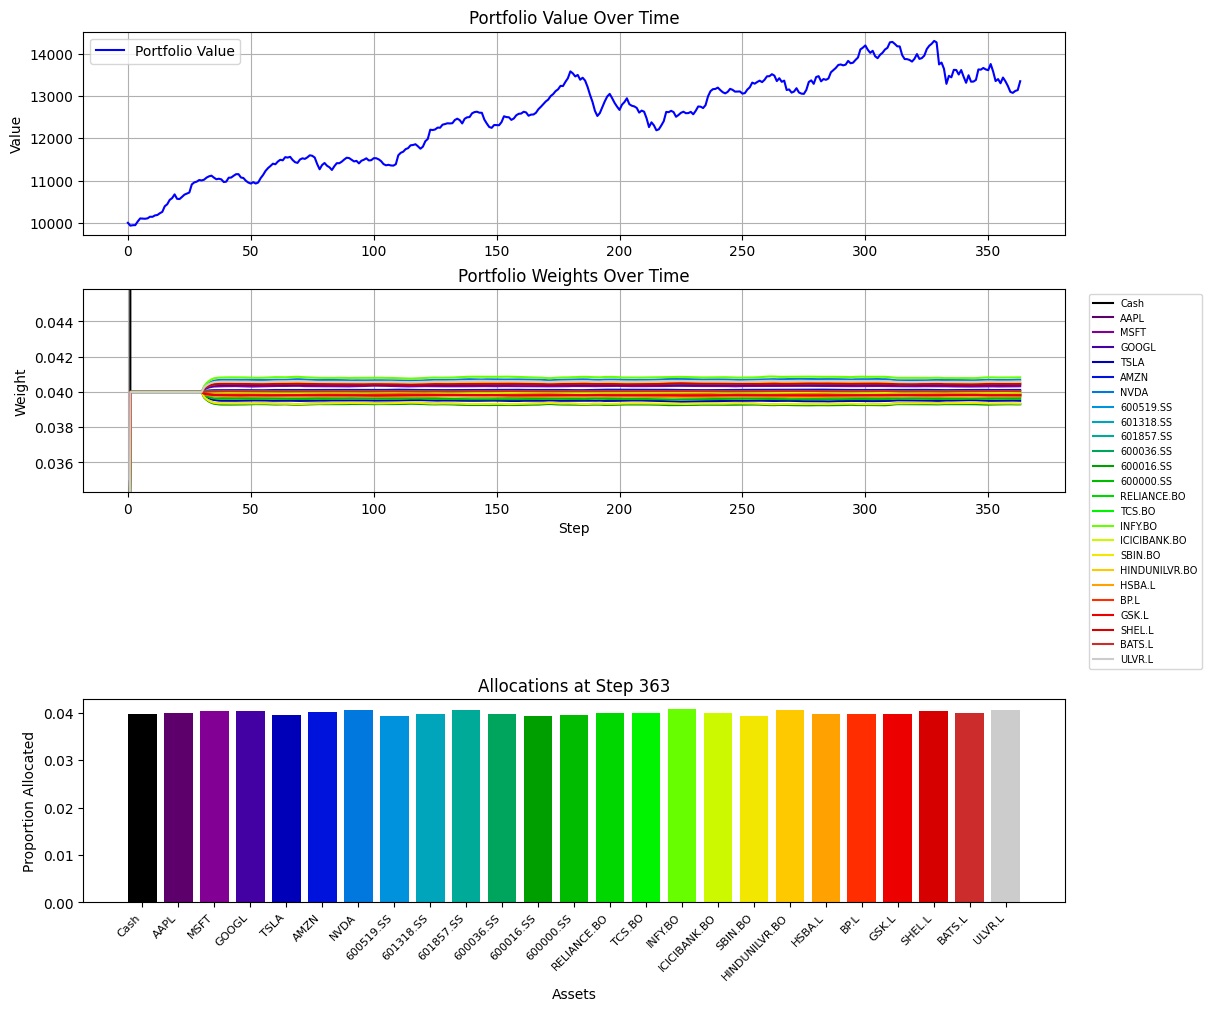

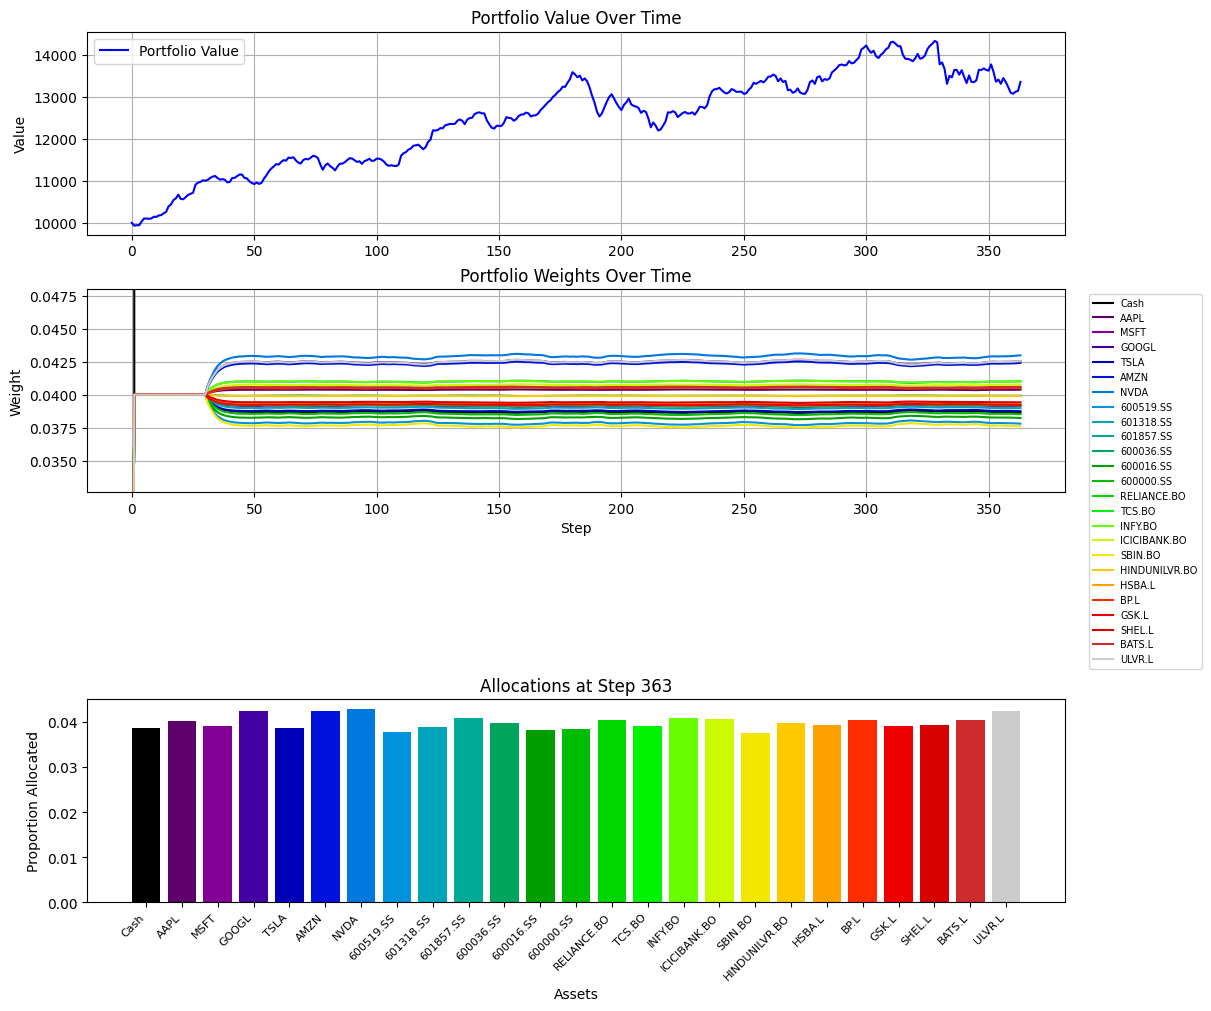

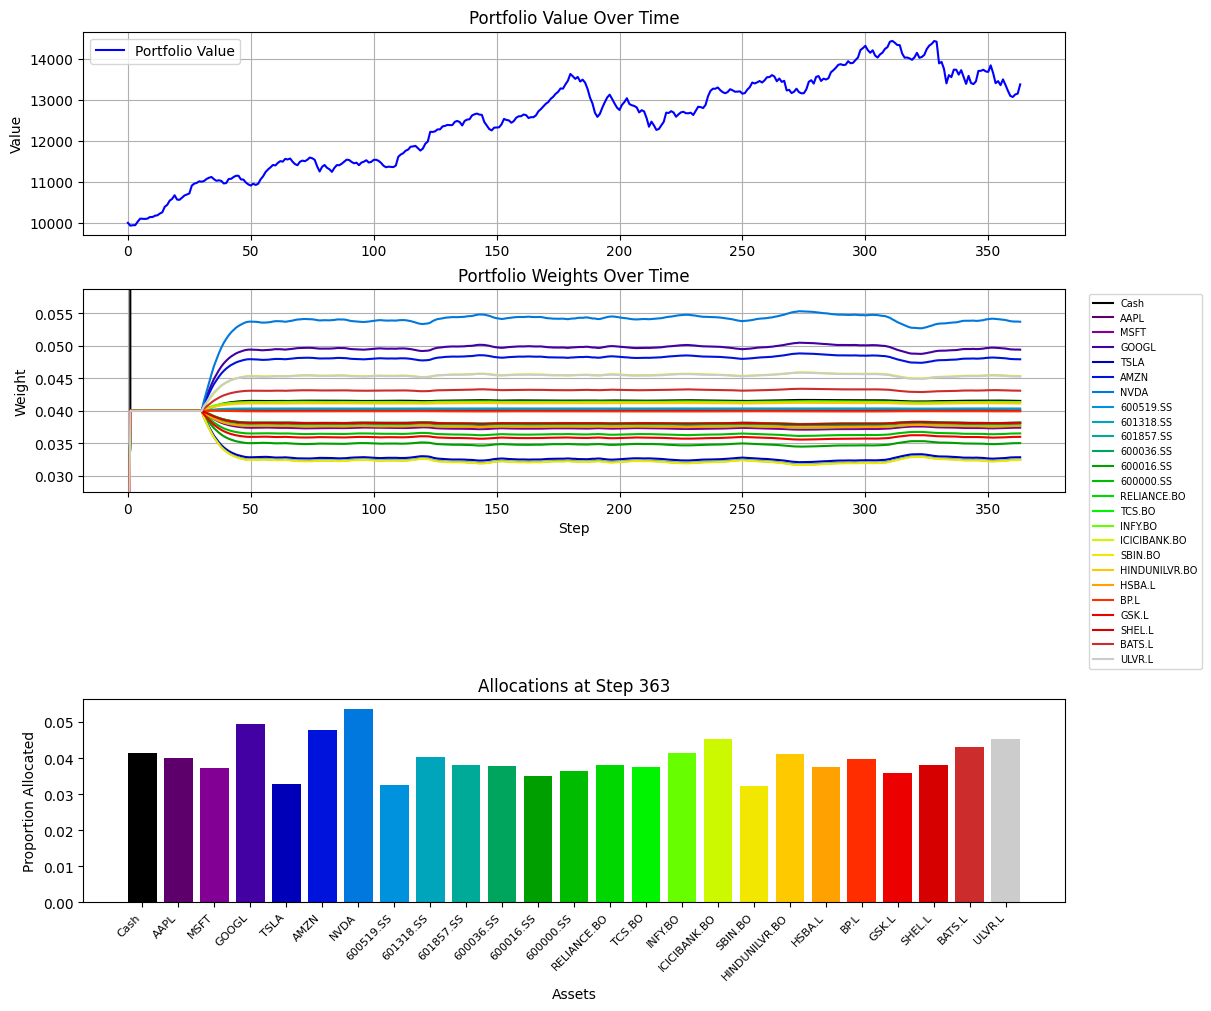

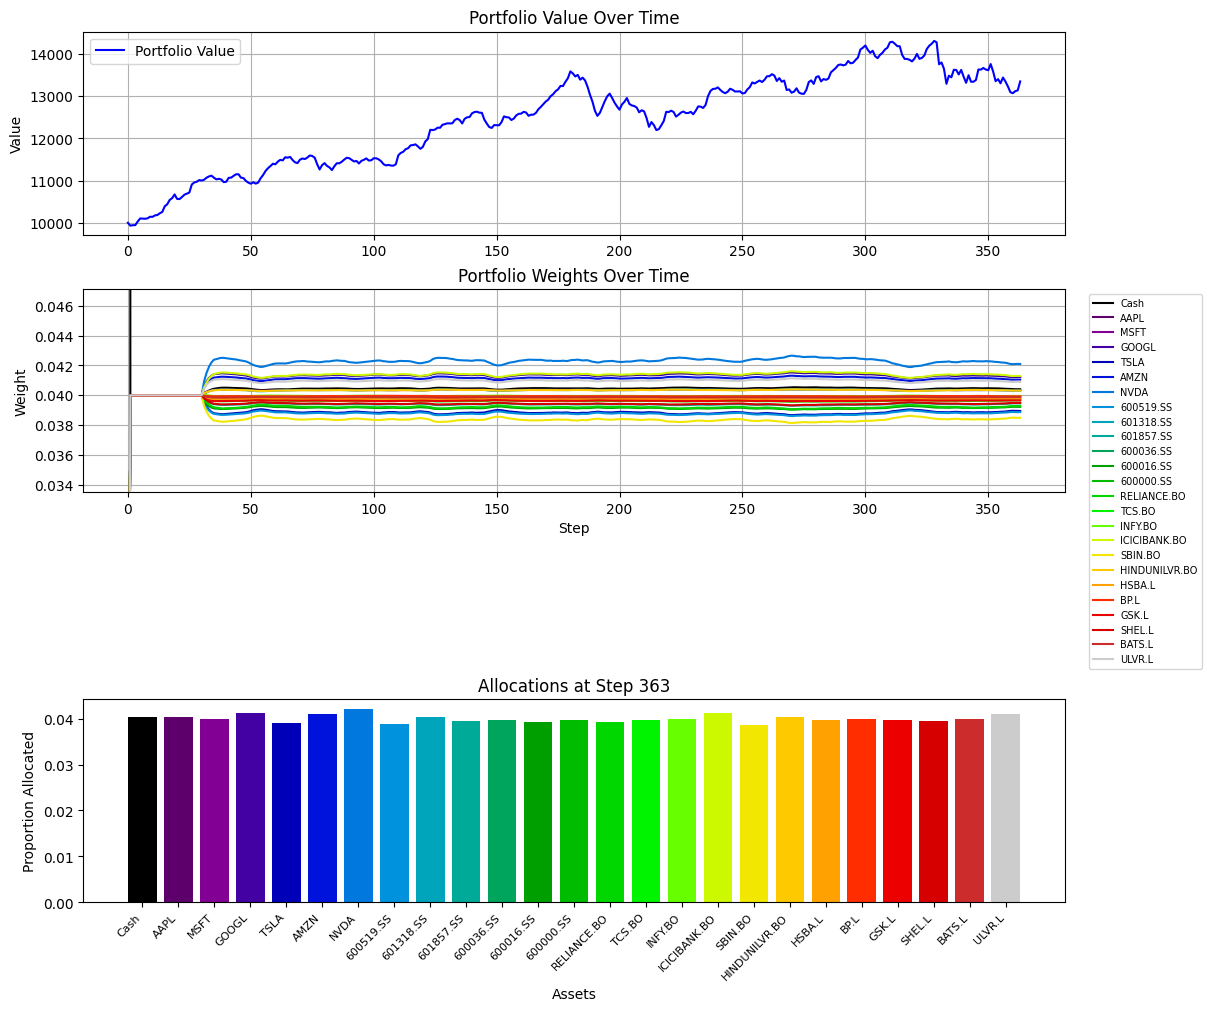

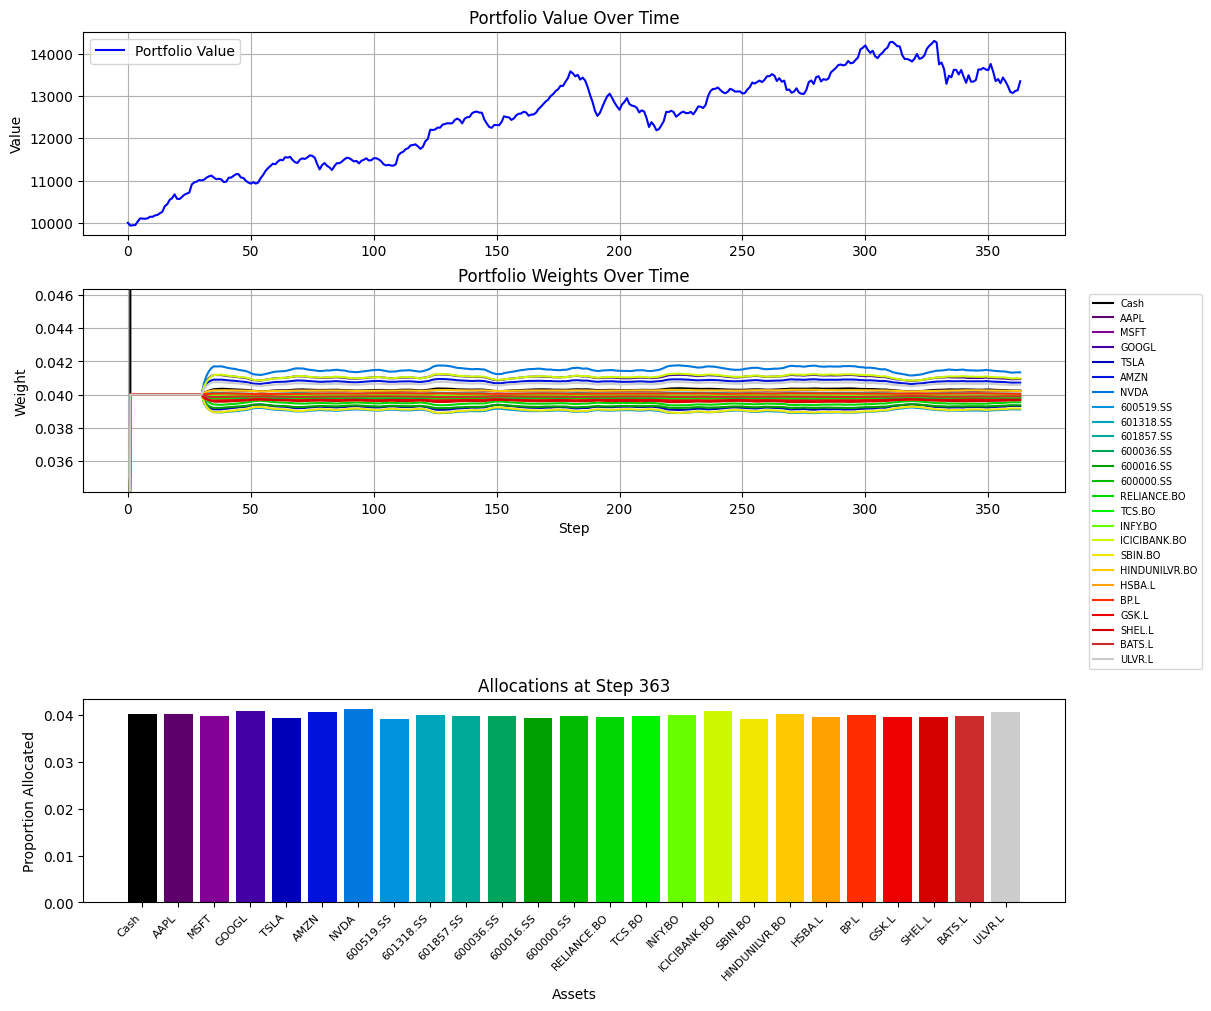

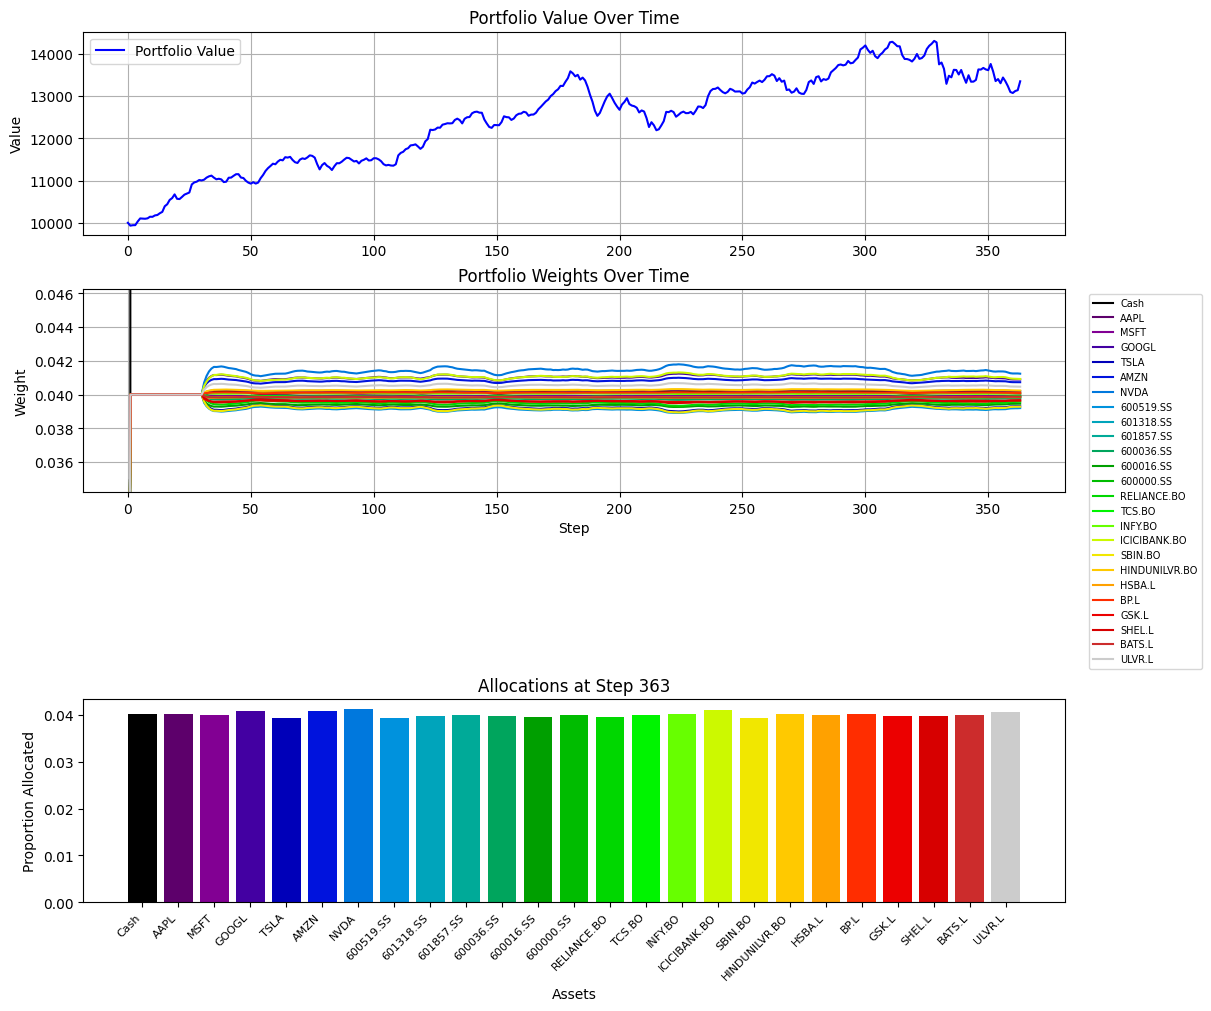

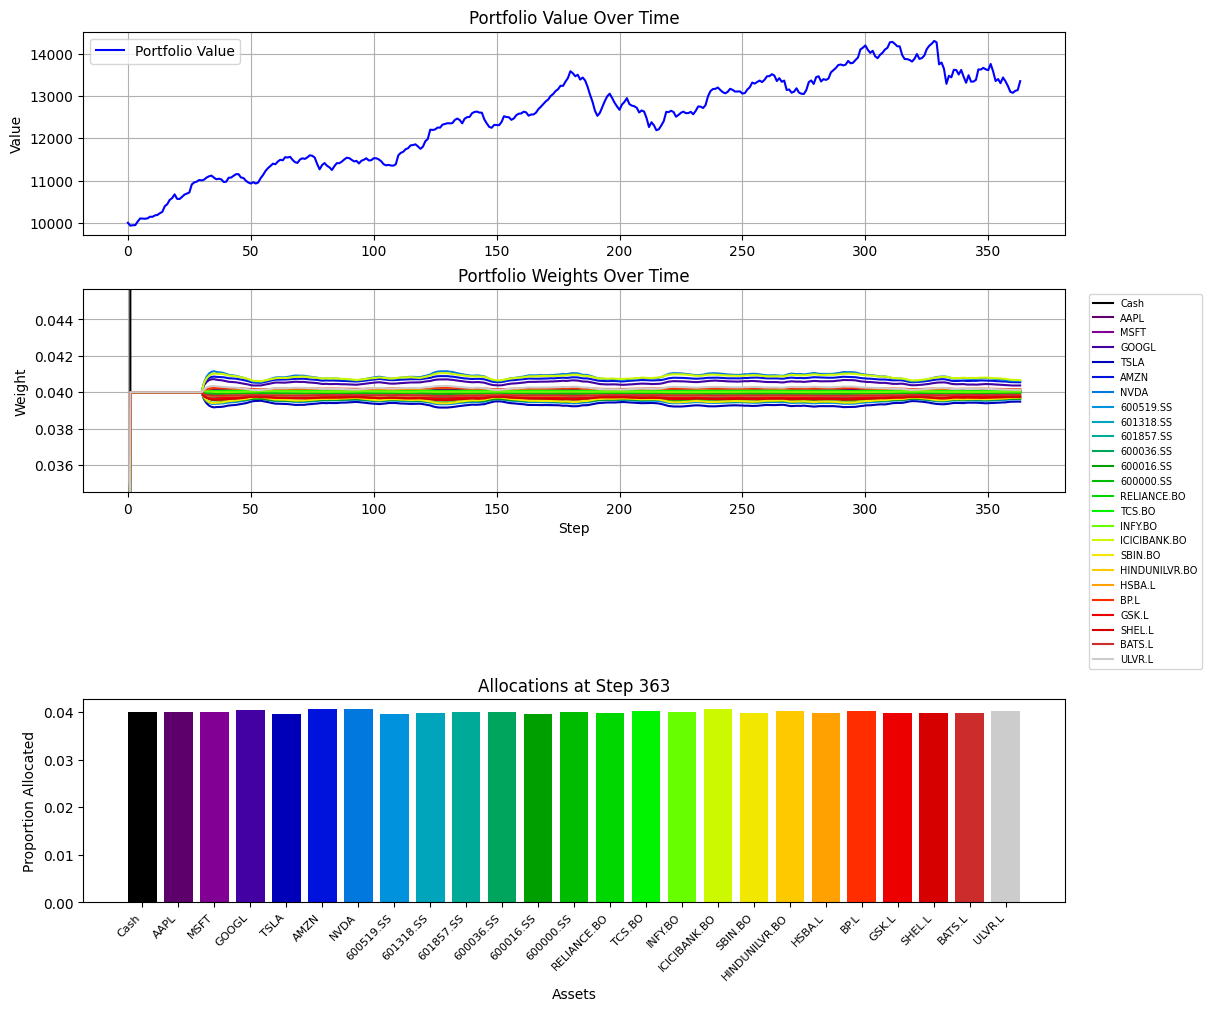

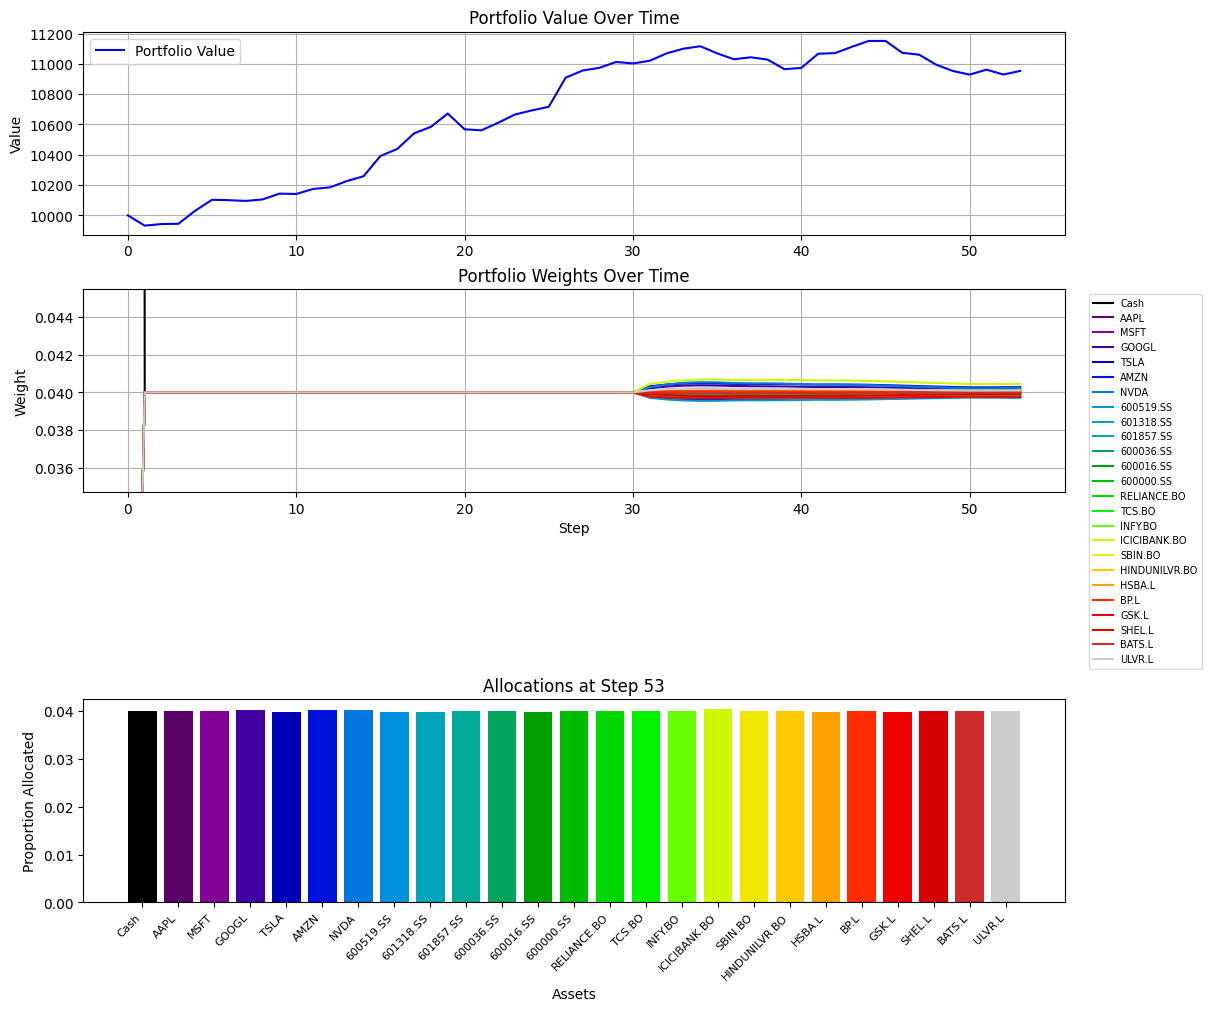

In [15]:
portVals = dict()
normalisationFolder = "portfolios/Normalisation/"
EPOCHS = 25 # approx 200k timesteps

NORMALIZE_DATA = True
PERTURBATION_NOISE = 0 #Just seeing if it can even fit to the data

NORM_TESTING = True 
if NORM_TESTING:
    for s in VARIED_BASE_SEEDS:
        BASE_SEED = s
        phase = "data_normalisation"
        cfg = getConfig(phase)
        seed(BASE_SEED) # Seed agent initialization and updates
        wandb.init(
                    project=PROJECT_NAME,
                    config=cfg,
                    name=f"exp-{phase}"
                        + ("_NO_" if not SCALE_LOG_REWARD else "") + "SCALING"
                        + ("_NORM" if NORMALIZE_DATA else ""),
                    reinit=True,
                    group=cfg["group"],
                    mode="disabled" 
                )
        config = wandb.config

        agent = generateAgent(config)

        if wandb.run is not None:
            wandb.watch(agent.actor, log="all")
            wandb.watch(agent.critic, log="all")
            wandb.watch(agent.featureExtractor, log="all")

        print("*" * 50)
        print("Testing Seed: " , s)
        portVals[s] = trainingLoop(agent, useNoiseEval=False, save=False, stage = phase)
        desiredFolder = f"{normalisationFolder}{s}/"
        if not os.path.exists(desiredFolder):
            os.makedirs(desiredFolder)
        np.savetxt(f"{desiredFolder}validationPerformances.txt", portVals[s]["validation_performances"], fmt='%f')
        np.savetxt(f"{desiredFolder}trainingRewards.txt", portVals[s]["epoch_reward"], fmt='%f')
        
        print("*" * 50)
        wandb.finish()

NORMALIZE_DATA = False

EPOCHS = 25

#### 4.2.1 Normalisation Plotted

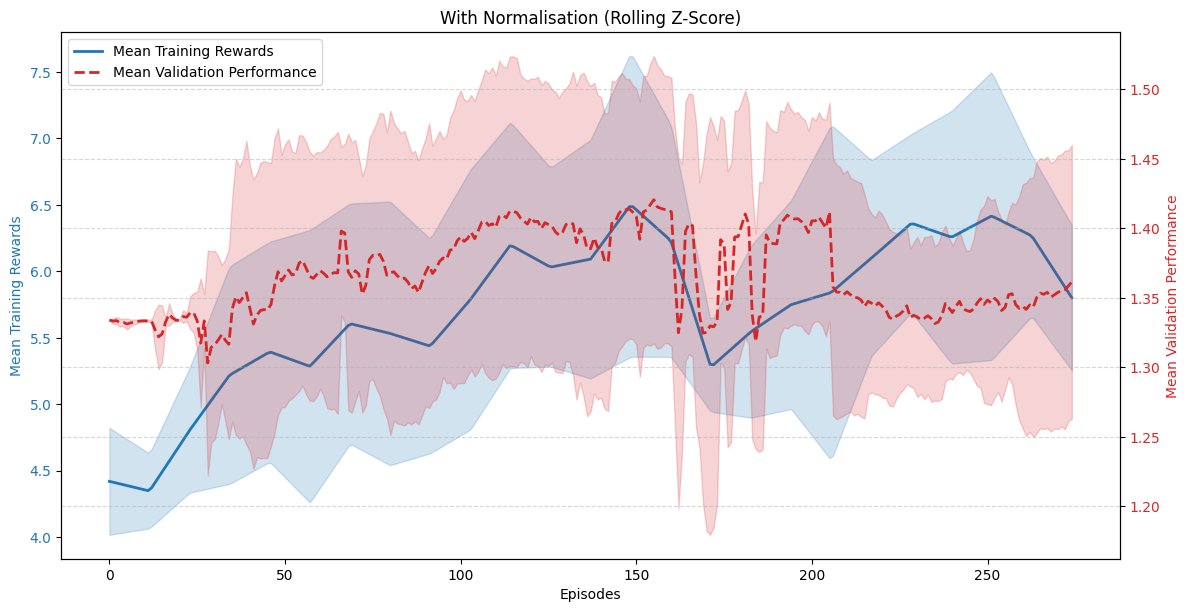

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_performance(folderPath, title="Mean Training Rewards & Validation Performance Over Training Period", saveFile=None):
    """
    Reads data from numbered subdirectories under folderPath, computes the mean and standard deviation
    across the runs for training rewards and validation performances, and plots the result.
    
    Parameters:
    - folderPath (str): The path to the folder containing numbered subdirectories for each run.
    - title (str): Plot title.
    - saveFile (str or None): If provided, the figure is saved to this file.
    
    Returns:
    - fig (matplotlib.figure.Figure): The created figure.
    """
    # Initialize containers.
    trainingRewardsAll = []
    validationPerformancesAll = []
    trainingRewardsStdAll = []
    validationPerformancesStdAll = []
    
    numDirectories = 0
    
    # Iterate through numeral directories in folderPath.
    for number in os.listdir(folderPath):
        numberDir = os.path.join(folderPath, number)
        if os.path.isdir(numberDir):
            trainingRewardsPath = os.path.join(numberDir, 'trainingRewards.txt')
            validationPerformancesPath = os.path.join(numberDir, 'validationPerformances.txt')
            
            if os.path.exists(trainingRewardsPath) and os.path.exists(validationPerformancesPath):
                trainingRewards = np.loadtxt(trainingRewardsPath)
                validationPerformances = np.loadtxt(validationPerformancesPath)
                
                # Initialize on the first valid directory.
                if numDirectories == 0:
                    trainingRewardsAll = np.zeros_like(trainingRewards)
                    validationPerformancesAll = np.zeros_like(validationPerformances)
                    trainingRewardsStdAll = []
                    validationPerformancesStdAll = []
                
                # Sum values element-wise.
                trainingRewardsAll += trainingRewards
                validationPerformancesAll += validationPerformances
                
                # Store arrays for std computation.
                trainingRewardsStdAll.append(trainingRewards)
                validationPerformancesStdAll.append(validationPerformances)
                
                numDirectories += 1
            else:
                print(f"Skipping directory {numberDir} as it does not contain the required files.")

    # Compute means.
    trainingRewardsMean = trainingRewardsAll / numDirectories
    validationPerformancesMean = validationPerformancesAll / numDirectories

    # Compute standard deviations.
    trainingRewardsStd = np.std(trainingRewardsStdAll, axis=0)
    validationPerformancesStd = np.std(validationPerformancesStdAll, axis=0)

    # Rescale Training Rewards if lengths differ.
    validationLength = len(validationPerformancesMean)
    trainingLength = len(trainingRewardsMean)
    if trainingLength < validationLength:
        xOld = np.linspace(0, 1, trainingLength)
        xNew = np.linspace(0, 1, validationLength)
        trainingRewardsMean = np.interp(xNew, xOld, trainingRewardsMean)
        trainingRewardsStd = np.interp(xNew, xOld, trainingRewardsStd)

    # Plotting.
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    color = 'tab:blue'
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Mean Training Rewards", color=color)
    line1 = ax1.plot(trainingRewardsMean, color=color, label="Mean Training Rewards", linewidth=2)
    ax1.fill_between(range(len(trainingRewardsMean)), 
                     trainingRewardsMean - trainingRewardsStd, 
                     trainingRewardsMean + trainingRewardsStd, 
                     color=color, alpha=0.2)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Secondary axis for validation performance.
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel("Mean Validation Performance", color=color)
    line2 = ax2.plot(validationPerformancesMean, color=color, label="Mean Validation Performance", 
                     linewidth=2, linestyle="dashed")
    ax2.fill_between(range(len(validationPerformancesMean)), 
                     validationPerformancesMean - validationPerformancesStd, 
                     validationPerformancesMean + validationPerformancesStd, 
                     color=color, alpha=0.2)
    ax2.tick_params(axis='y', labelcolor=color)

    # Combine legends from both axes.
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', fontsize=10)

    fig.tight_layout()
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    if saveFile:
        plt.savefig(saveFile)
    plt.show()
    return fig

# Plot for the Normalisation folder.
normalisationFolder = "portfolios/Normalisation/"
figure = plot_mean_performance(normalisationFolder, title="With Normalisation (Rolling Z-Score)", saveFile="plots/NormalisationEffect.png")

### 4.3.0 Example effect of noise on Prices

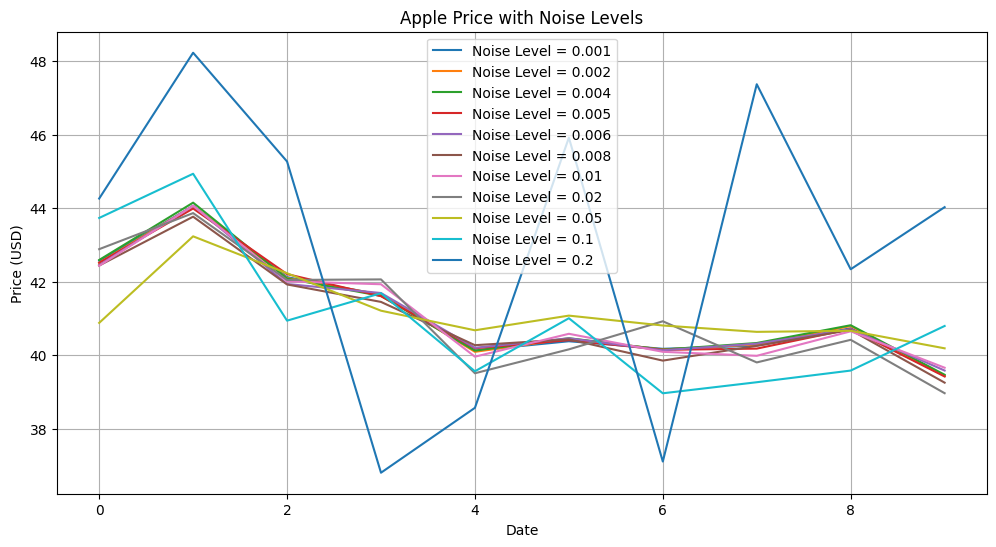

In [ ]:
noises = [1e-3, 2e-3, 4e-3, 5e-3, 6e-3, 8e-3, 1e-2, 0.02, 0.05, 0.1, 0.2] #Do 0.2 if you want - barely visible.

PLOT_NOISE_EFFECT = True
horizon = 10 #time horizon to visualize over

def plotNoiseEffect():
    """
    Plot the Apple stock prices from the testing data.
    """
    plt.figure(figsize=(12, 6))
    for nVal in noises:
        testData = TESTING_DATA["AAPL"].copy()
        noise = np.random.normal(0, nVal, size=testData.shape)
        frame = testData + (noise * testData.std().values)
        closingPrices = frame["Close"].values
        plt.plot(closingPrices[:max(min(horizon, len(closingPrices)), 2)], label=f"Noise Level = {nVal}")
    
    plt.title('Apple Price with Noise Levels')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

if PLOT_NOISE_EFFECT:
    """
    Plot the noise effect on the Apple stock prices.
    """
    plotNoiseEffect()

### 4.3.1. Noise Analysis

In [148]:
import os
import numpy as np
import wandb

"""
WE DECIDED TO NORMALISE. REMEMBER THIS!!!!!
"""
NORMALIZE_DATA = True  


noises = [0, 1e-3, 2e-3, 4e-3, 5e-3, 6e-3, 8e-3, 1e-2, 0.02, 0.05]
portVals = dict()

# Folder paths
noiseFolder = f"portfolios/noises/{'Normalisation' if NORMALIZE_DATA else 'NonNormalisation'}/"
nonNormFolder = f"portfolios/{'Normalisation' if NORMALIZE_DATA else 'NonNormalisation'}/"

# Create the base directories if they don't exist
if not os.path.exists(noiseFolder):
    os.makedirs(noiseFolder)
if not os.path.exists(nonNormFolder):
    os.makedirs(nonNormFolder)

OLD_EPOCHS = 25  # approx 200k timesteps
NOISETESTING = False  # Set to True to test noise perturbations on the training data

if NOISETESTING:
    # Uses default hyperparameters to sweep over different noise values 
    # and see where training is problematic.
    EPOCHS = OLD_EPOCHS
    for s in VARIED_BASE_SEEDS:
        BASE_SEED = s
        for noise in noises:
            phase = "noise_testing"
            cfg = getConfig(phase)
            seed(BASE_SEED)  # Seed agent initialization
            wandb.init(
                project=PROJECT_NAME,
                config=cfg,
                name=f"exp-{phase}-{noise}_"
                     + ("_NO_" if not SCALE_LOG_REWARD else "") + "SCALING"
                     + ("_NORM" if NORMALIZE_DATA else "") + "BASE_SEED_" + str(BASE_SEED),
                reinit=True,
                group=cfg["group"],
                mode="online"
            )
            config = wandb.config

            agent = generateAgent(config)

            if wandb.run is not None:
                wandb.watch(agent.actor, log="all")
                wandb.watch(agent.critic, log="all")
                wandb.watch(agent.featureExtractor, log="all")

            print("*" * 50)
            print("Testing Noise: ", noise)
            PERTURBATION_NOISE = noise
            portVals[noise] = trainingLoop(agent, useNoiseEval=False, save=False)
            
            # Save to the noise folder
            folderForSavingNoise = f"{noiseFolder}{s}/"
            if not os.path.exists(folderForSavingNoise):
                os.makedirs(folderForSavingNoise)
            np.savetxt(f"{folderForSavingNoise}{noise}.txt", portVals[noise]["validation_performances"], fmt='%f')
            
            # If noise is zero, also save to the non-normalisation folder
            if noise == 0:
                folderForSavingNormOrNonNorm = f"{nonNormFolder}{s}/"
                if not os.path.exists(folderForSavingNormOrNonNorm):
                    os.makedirs(folderForSavingNormOrNonNorm)
                np.savetxt(f"{folderForSavingNormOrNonNorm}validationPerformances.txt", portVals[noise]["validation_performances"], fmt='%f')
                np.savetxt(f"{folderForSavingNormOrNonNorm}trainingRewards.txt", portVals[noise]["epoch_reward"], fmt='%f')
            print("*" * 50)
            wandb.finish()

EPOCHS = 25  # Set EPOCHS back or use best performing value as needed.

#### **4.2.1.1 - Comparison With No Normalisation**

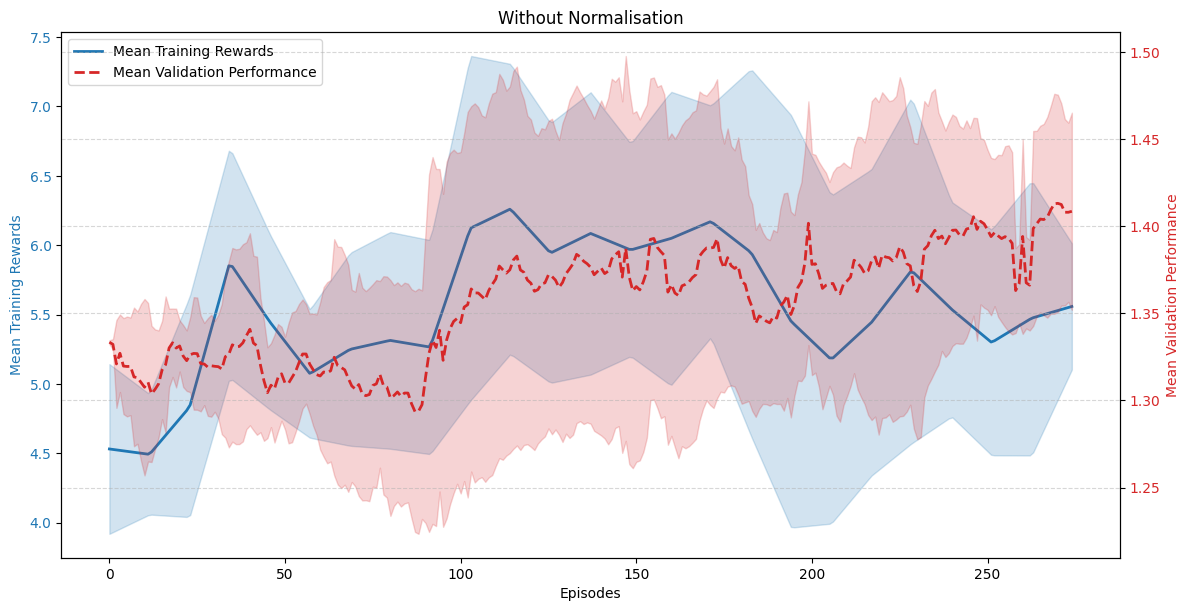

In [149]:

# Plot for the NonNormalisation folder.
nonNormalisationFolder = "portfolios/NonNormalisation/"
figure = plot_mean_performance(nonNormalisationFolder, title="Without Normalisation", saveFile="plots/NonNormalisationEffect.png")

In [150]:
def computeWeightedAUC(yValues, xValues=None, weightPower=1.0):
    """
    Computes a weighted Area Under Curve (AUC) for a learning curve. Helps to score noise levels
    """
    yValues = np.asarray(yValues)
    if xValues is None:
        xValues = np.arange(len(yValues))
    xValues = np.asarray(xValues)
    normTime = (xValues - xValues.min()) / (xValues.max() - xValues.min())
    weights = normTime ** weightPower
    weightedY = yValues * weights
    auc = np.trapezoid(weightedY, xValues)
    totalWeight = np.trapezoid(weights, xValues)
    normalizedAUC = auc / totalWeight if totalWeight > 0 else 0
    return normalizedAUC



σ=0: Weighted AUC (Normalized) = 36.73
Saved plot for σ=0.
σ=0.001: Weighted AUC (Normalized) = 36.92
Saved plot for σ=0.001.
σ=0.002: Weighted AUC (Normalized) = 31.37
Saved plot for σ=0.002.
σ=0.004: Weighted AUC (Normalized) = 35.80
Saved plot for σ=0.004.
σ=0.005: Weighted AUC (Normalized) = 36.23
Saved plot for σ=0.005.
σ=0.006: Weighted AUC (Normalized) = 38.36
Saved plot for σ=0.006.
σ=0.008: Weighted AUC (Normalized) = 35.12
Saved plot for σ=0.008.
σ=0.01: Weighted AUC (Normalized) = 40.09
Saved plot for σ=0.01.
σ=0.02: Weighted AUC (Normalized) = 36.23
Saved plot for σ=0.02.
σ=0.05: Weighted AUC (Normalized) = 36.06
Saved plot for σ=0.05.
Generally, the normalisation makes performance over the training period: 71.2 %) of the time better than the non-normalised data.
Should normalise =  True

--- Weighted AUC (Normalized) Summary ---
σ=0.010 -> AUC: 40.09
σ=0.006 -> AUC: 38.36
σ=0.001 -> AUC: 36.92
σ=0.000 -> AUC: 36.73
σ=0.005 -> AUC: 36.23
σ=0.020 -> AUC: 36.23
σ=0.050 -> AUC

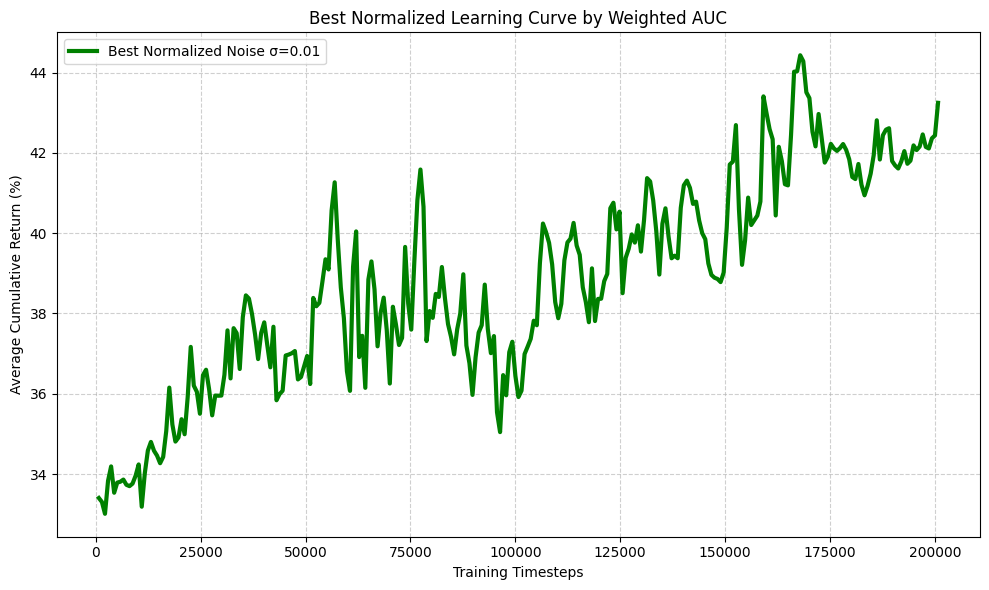

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import os

WINDOW = 1
SHOW_STD = False  # Set to True to show shaded standard deviation

# Flattened list of all noise levels
noiseLevels = [0, 1e-3, 2e-3, 4e-3, 5e-3 , 6e-3, 8e-3, 1e-2 , 0.02, 0.05]

# Ensure plot directory exists
os.makedirs("plots", exist_ok=True)

def loadResults(baseDir, noiseLevel):
    """Load performance arrays for a noise level across all seeds."""
    allRuns = []
    for seed in VARIED_BASE_SEEDS:
        filePath = f"{baseDir}{seed}/{noiseLevel}.txt"
        if os.path.exists(filePath):
            data = np.loadtxt(filePath)
            processed = (data - 1) * 100
            allRuns.append(processed)
    return allRuns

def smooth(data, window):
    """Apply simple moving average."""
    if len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

def computeWeightedAUC(yValues, xValues=None, weightPower=1.0):
    yValues = np.asarray(yValues)
    if xValues is None:
        xValues = np.arange(len(yValues))
    xValues = np.asarray(xValues)
    normTime = (xValues - xValues.min()) / (xValues.max() - xValues.min())
    weights = normTime ** weightPower
    weightedY = yValues * weights
    auc = np.trapezoid(weightedY, xValues)
    totalWeight = np.trapezoid(weights, xValues)
    normalizedAUC = auc / totalWeight if totalWeight > 0 else 0
    return normalizedAUC

meanPercentageAboves = []
aucResults = []

# Variables to track best normalized curve
bestAuc = -np.inf
bestNoiseLevel = None
bestCurveX = None
bestCurveY = None

def plotNoiseComparison(noiseLevel):
    global bestAuc, bestNoiseLevel, bestCurveX, bestCurveY

    normFolder = "portfolios/noises/Normalisation/"
    nonNormFolder = "portfolios/noises/NonNormalisation/"

    normResults = loadResults(normFolder, noiseLevel)
    nonNormResults = loadResults(nonNormFolder, noiseLevel)

    if not normResults or not nonNormResults:
        print(f"Skipping σ={noiseLevel} — missing data.")
        return

    # Compute stats
    normMean = np.mean(normResults, axis=0)
    normStd = np.std(normResults, axis=0)
    nonNormMean = np.mean(nonNormResults, axis=0)
    nonNormStd = np.std(nonNormResults, axis=0)

    # Smooth
    normMeanSmooth = smooth(normMean, WINDOW)
    normStdSmooth = smooth(normStd, WINDOW)
    nonNormMeanSmooth = smooth(nonNormMean, WINDOW)
    nonNormStdSmooth = smooth(nonNormStd, WINDOW)

    percentageAbove = np.mean(normMeanSmooth > nonNormMeanSmooth) * 100
    meanPercentageAboves.append(percentageAbove)

    # Time axis
    xValues = np.linspace(WINDOW, EPOCHS * TRAINING_WINDOWS, len(normMeanSmooth)) * EPISODE_LENGTH

    # Compute weighted AUC for normalized only
    aucNorm = computeWeightedAUC(normMeanSmooth, xValues, weightPower=1.0)
    print(f"σ={noiseLevel}: Weighted AUC (Normalized) = {aucNorm:.2f}")
    aucResults.append((noiseLevel, aucNorm))

    # Track best normalized curve
    if aucNorm > bestAuc:
        bestAuc = aucNorm
        bestNoiseLevel = noiseLevel
        bestCurveX = xValues
        bestCurveY = normMeanSmooth

    # Plot comparison curves
    plt.figure(figsize=(10, 6))
    plt.plot(xValues, normMeanSmooth, label="Normalized", linewidth=2, color='blue')
    plt.plot(xValues, nonNormMeanSmooth, label="Non-Normalized", linewidth=2, color='orange')

    if SHOW_STD:
        plt.fill_between(xValues, normMeanSmooth - normStdSmooth, normMeanSmooth + normStdSmooth, color='blue', alpha=0.3)
        plt.fill_between(xValues, nonNormMeanSmooth - nonNormStdSmooth, nonNormMeanSmooth + nonNormStdSmooth, color='orange', alpha=0.3)

    plt.title(f"Noise Level σ={noiseLevel} Comparison")
    plt.xlabel("Training Timesteps")
    plt.ylabel("Average Cumulative Return (%)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/noiseComparison_sigma_{noiseLevel}.png")
    plt.close()
    print(f"Saved plot for σ={noiseLevel}.")

# ---- MAIN LOOP ----
for noise in noiseLevels:
    plotNoiseComparison(noise)

print(f"Generally, the normalisation makes performance over the training period: {round(np.mean(meanPercentageAboves), 2)} %) of the time better than the non-normalised data.")
print("Should normalise = ", np.mean(meanPercentageAboves) > 50)

# After plotting all noise levels
aucResults.sort(key=lambda x: x[1], reverse=True)
print("\n--- Weighted AUC (Normalized) Summary ---")
for sigma, auc in aucResults:
    print(f"σ={sigma:.3f} -> AUC: {auc:.2f}")

# Plot the best normalized curve by weighted AUC
if bestCurveX is not None and bestCurveY is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(bestCurveX, bestCurveY, label=f"Best Normalized Noise σ={bestNoiseLevel}", linewidth=3, color='green')
    plt.xlabel("Training Timesteps")
    plt.ylabel("Average Cumulative Return (%)")
    plt.title("Best Normalized Learning Curve by Weighted AUC")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


#### ~~4.4. Training Models~~

In [152]:
def sweep():
    """
    Hyperparameter sweep function.

    For the active test defined in the TESTING dictionary, this function iterates over
    the corresponding hyperparameter values. For each value, it creates a configuration
    using getConfig (in the "hyperparameter_tuning" phase), generates an agent with generateAgent,
    and then calls trainingLoop with that agent and configuration.
    """
    # Map test types to their corresponding hyperparameter values and overrides.
    # For each override, if the value is None, then substitute the sweep value.
    sweep_params = {
        "RISK AVERSION": {
            "values": AGENT_RISK_AVERSIONS,
            "overrides": {"risk_aversion": None}
        },
        "LSTM OUTPUT SIZE": {
            "values": LSTMOUTPUTSIZES,
            "overrides": {"lstm_output_size": None}
        },
        "REWARD FUNCTION": {
            "values": REWARD_FUNCTIONS,
            "overrides": {"reward_function": None}
        },
        "LEARNING FREQUENCY": {
            "values": LEARNING_FREQUENCIES,
            "overrides": {"learning_frequency": None}
        },
        "LEARNING RATE": {
            "values": LEARNING_RATES,
            "overrides": {"learning_rate": None}
        }
    }
    phase = "hyperparameter_tuning"

    # Iterate over active test types defined in TESTING
    for testType, active in TESTING.items():
        if active and testType in sweep_params:
            param_info = sweep_params[testType]
            for value in param_info["values"]:
                print(f"Running sweep for {testType}: {value}")
                # Build the overrides dict, substituting sweep values where needed.
                overrides = {
                    key: (value if override is None else override)
                    for key, override in param_info["overrides"].items()
                }
                agentCfg = getConfig(phase, optionalHyperConfig=overrides)
                agent = generateAgent(agentCfg)

                wandb.init(project=PROJECT_NAME, config=agentCfg, name=f"exp-{phase}-{testType}-{value}", reinit=True)  
                config = wandb.config

                agent = generateAgent(config)

                if wandb.run is not None:
                    wandb.watch(agent.actor, log="all")
                    wandb.watch(agent.critic, log="all")
                    wandb.watch(agent.featureExtractor, log="all")

                trainingLoop(agent)
            break  # Run only one active test type per sweep


def hyperSweep():
    """
    Runs the hyperparameter sweep by sequentially activating one test type at a time.
    """
    for key in list(TESTING.keys()):
        print("=" * 50)
        TESTING[key] = True
        sweep()
        TESTING[key] = False
        print("=" * 50)


# PERTURBATION_NOISE = 0  # temporary
# EPOCHS = 3             
TRAIN = False           # Set to True to run the sweep

"""
NEEDS TO BE CHECKED TO ENSURE THE CONFIG IS CORRECT
"""

# Example usage:
if TRAIN:
    hyperSweep()

### 4.5. Evaluation

#### 4.5.0. Scoring Functions

In [153]:
def maxDrawdown(arr):
    # Maximum Drawdown calculation
    maxValue = float("-inf")
    maxDrawdown = 0.0
    for value in arr:
        maxValue = max(maxValue, value)
        drawdown = (maxValue - value) / maxValue 
        maxDrawdown = max(maxDrawdown, drawdown)
    return maxDrawdown

#Scoring Formula
def scoreFormula(agentArray, averageRandomReturn):
    # score by (cumulative return - average random return)/max drawdown all times sharpe ratio
    cumulativeReturn = agentArray[-1] / START_CASH - 1
    maximumDrawdown = maxDrawdown(agentArray)
    percChange = np.diff(agentArray) / agentArray[:-1]
    sharpe = np.mean(percChange)/np.std(percChange) if np.std(percChange) != 0 else 0
    score = ((cumulativeReturn - averageRandomReturn) / maximumDrawdown) * np.abs(sharpe)
    metrics = {
        "Cumulative \nReturn (%)": cumulativeReturn * 100,
        "Maximum \nDrawdown (%)": maximumDrawdown * 100,
        "Sharpe Ratio": sharpe,
        "Score": score
    }
    return metrics


#### 4.5.1. Functions Called by 4.5.2

In [154]:
NOISE_ITERATIONS_VALIDATION = 10

HYPERS = {
    "Risk Aversion" : AGENT_RISK_AVERSIONS,
    "LSTM Output Size" : LSTMOUTPUTSIZES,
    "Reward Function" : REWARD_FUNCTIONS,
    "Learning Frequency": LEARNING_FREQUENCIES, 
    "Learning Rate": LEARNING_RATES,
    }


def setParameters(parameter, hyper, riskAversion):
    """
    When Evaluating hyperparameters, this function is called to set the parameters of the agent.
    """
    rf = "Standard Logarithmic Returns"
    freq = int(EPISODE_LENGTH / 30)
    lr = 3e-4
    risk = parameter if hyper == "Risk Aversion" else riskAversion
    lstmOutputSize = 128
    if hyper == "Risk Aversion":
        agent = generateAgent(lstmOutputSize, parameter, lr, freq)
    elif hyper == "Learning Frequency":
        freq = parameter
        agent = generateAgent(lstmOutputSize, risk, lr, freq)
    elif hyper == "Reward Function":
        rf = parameter
        agent = generateAgent(lstmOutputSize, risk, lr, freq)
    elif hyper == "LSTM Output Size":
        agent = generateAgent(parameter, risk, lr, freq)
    elif hyper == "Learning Rate":
        lr = parameter
        agent = generateAgent(lstmOutputSize, risk, parameter, freq)
    return rf, freq, risk, agent, lr

def validationAgentsLoop(dataType, riskAversion, lr, noiseIteration, performances):
    """
    This just loops over every single hyperparameter and runs the evaluation function for each one.
    The performances dictionary stores the portfolio trajectory for each evaluation loop.
    """
    for hyper, param in HYPERS.items():
        TESTING[hyper.upper()] = True
        for epo in range(1, EPOCHS + 1):
            for parameter in param:
                saveFolder = f"save/{dataType}/{epo * TRAINING_WINDOWS}/{hyper}-{parameter}/"
                rf, freq, risk, agent, lr = setParameters(parameter, hyper, riskAversion)
                agent.load(saveFolder)
                portfolioValues = evaluateAgent(risk, rf, agent, freq, lr=lr, num=epo * TRAINING_WINDOWS, conf=None, save=False, epoch = noiseIteration) # ignore standard log - agent is not learning here
                performances[saveFolder].append(portfolioValues) 
        TESTING[hyper.upper()] = False

def testAgentsLoop(dataType, rewardFunctions, bestParams, performances):
    """
    This is a simpler loop that simply runs the evaluation function for each reward function.
    This is called later on to see how each checkpointed testing agent (saved at each epoch) performs on the test set.
    """
    for rewardFunc in rewardFunctions:
        TESTING["REWARD FUNCTION"] = True
        for epoch in range(1, EPOCHS + 1):
            saveFolder = f"save/{dataType}/{epoch*TRAINING_WINDOWS}/Reward Function-{rewardFunc}"
            # agent = PPOAgent( 
            #             state_n=bestParams["LSTM Output Size"], 
            #             actions_n=len(productIds) + 1,
            #             alpha=bestParams["Learning Rate"],
            #             policyClip = 0.2,
            #             gamma=0.99,
            #             lstmHiddenSize=LSTMHIDDENSIZE,
            #             actor_noise=0,
            #             batch_size=int(bestParams["Frequency"]),
            #             fc1_n=128,
            #             fc2_n=128,
            #             gaeLambda=0.98,
            #             epochs=1,
            #             riskAversion=None,#not required for the agent
            #             featureExtractor = LstmFeatureExtractor(NUMBER_OF_FEATURES, 128, bestParams["LSTM Output Size"]),
            #             maxSize=bestParams["Frequency"],
            #             nonFeatureStateDim = (TIME_WINDOW, NUMBER_OF_FEATURES),
            #                 )
            agent.load(saveFolder)
            portfolioValues = evaluateAgent("", rewardFunc, agent, "", "", epoch*TRAINING_WINDOWS, dataType=dataType, save=False, epoch=epoch, showTable = False)
            performances[saveFolder].append(portfolioValues) 
        TESTING["REWARD FUNCTION"] = False

def runSavedAgents(lstmOutputSize = 128, riskAversion=0, lr=3e-4, freq=int(EPISODE_LENGTH / 30), dataType = "validation", rewardFunctions = None, bestParams=None):
    performances = defaultdict(list)
    start = time.time()
    # Since noise is added only to the validation data, we don't need to run the test data for multiple iterations
    iters = NOISE_ITERATIONS_VALIDATION if dataType == "validation" else 1
    for noiseIteration in range(iters):
        # The number of validation iterations referred to earlier
        if noiseIteration > 0:
            print(f"{noiseIteration} Noise Iterations takes: {(time.time() - start):.2f} seconds")
        if dataType == "validation":
            validationAgentsLoop(dataType, riskAversion,  lr, noiseIteration, performances)
        else:
            testAgentsLoop(dataType, rewardFunctions, bestParams, performances)
    return performances
                
RUN_SAVED_TRAINED_AGENTS = False                

if RUN_SAVED_TRAINED_AGENTS:
    runSavedAgents()
        

#### 4.5.2.  Assess

In [155]:
RANDOM_REPEATS = 1000

def runTestScoring(dataType, averageRandomReturn, performances, rewardFunc):
    """
    Essentially scores each final reward function model being tested.
    """
    table = [["Epoch/Model", "Cumulative \nReturn (%)", "Maximum \nDrawdown (%)", "Sharpe Ratio", "Score"]]
    for epoch in range(1, EPOCHS + 1):
        key = f"save/{dataType}/{epoch*TRAINING_WINDOWS}/Reward Function-{rewardFunc}"
        portfolioNumbers = performances[key]
        portfolioNumbers = np.mean(np.array(portfolioNumbers), axis=0)
        metrics = scoreFormula(portfolioNumbers, averageRandomReturn)
        table.append([f"Epoch {epoch}"] + [round(met, 4) for met in metrics.values()])
    tabulate_neatly(table, headers="firstrow", title=f"Reward Function-{rewardFunc} | Scores and Metrics Tabulated (Test Set)")

def runValidationScoring(dataType, averageRandomReturn, performances, hyper=None, param=None):
    """
    Essentially scores each hyperparameter model being tested. This will take something like 30 minutes to run.
    It returns quite a few html tables, providing a score for every hyperparameter at each epoch it was trained at.
    """
    moreData = defaultdict(lambda: float("-inf"))
    epochNumber = defaultdict(lambda: 0)
    bestMetrics = {}  

    for epoch in range(1, EPOCHS + 1):
        table = [["Hyperparameter", "Cumulative \nReturn (%)", "Maximum \nDrawdown (%)", "Sharpe Ratio", "Score"]]
        bestScore = float("-inf")
        bestParameter = None
        for parameter in param:
            key = f"save/{dataType}/{epoch * TRAINING_WINDOWS}/{hyper}-{parameter}/"
            portfolioNumbers = performances[key]
            portfolioNumbers = np.mean(np.array(portfolioNumbers), axis=0)
            metrics = scoreFormula(portfolioNumbers, averageRandomReturn)
            key = f"{hyper.title()}-{parameter}"
            if metrics["Score"] > moreData[key]:
                moreData[key] = metrics["Score"]
                epochNumber[key] = epoch
                bestMetrics[key] = metrics
            table.append([f"{hyper.title()}-{parameter}"] + [round(met, 4) for met in metrics.values()])
            if metrics["Score"] > bestScore:
                bestScore = metrics["Score"]
                bestParameter = f"{hyper.title()}-{parameter}"
        print(f"Epoch {epoch} | Best Hyperparameter: ", bestParameter)
        print(f"Epoch {epoch} | Best Score: ", bestScore)
        tabulate_neatly(table, headers="firstrow", title=f"Epoch: {epoch} | Scores and Metrics Tabulated")
    
    table2 = [["Hyperparameter", "Best Epoch", "Cumulative \nReturn (%)", "Maximum \nDrawdown (%)", "Sharpe Ratio", "Score"]]
    for key in bestMetrics.keys():
        m = bestMetrics[key]
        table2.append([
            key,
            epochNumber[key],
            round(m["Cumulative \nReturn (%)"], 4),
            round(m["Maximum \nDrawdown (%)"], 4),
            round(m["Sharpe Ratio"], 4),
            round(m["Score"], 4)
        ])
    tabulate_neatly(table2, headers="firstrow", title=f"Best Hyperparameters with Detailed Metrics: {hyper.title()}")

def scoreAgents(dataType="validation", rewardFunctions=None, perfs = None, runAgents=True):
    """
    A higher level scoring function that calls eather runValidationScoring or runTestScoring depending on the dataType.
    It also runs the random agent as a benchmark for the what is being tested.
    The base seed for the random agent is only varied during testing. A limitation. However, this is consistent with 
    the methodology described in my report.
    """
    global BASE_SEED
    ORIGINAL_BASE_SEED = BASE_SEED
    averageRandomPerformance = []
    for bench in range(RANDOM_REPEATS):
        if dataType == "testing": # prior code bug. Last minute changes meant that I did not specify varying the random base seeed only for testing.
            if bench % (RANDOM_REPEATS // len(VARIED_BASE_SEEDS)) == 0 and VARIED_BASE_SEEDS:  
                BASE_SEED = VARIED_BASE_SEEDS.pop()
        randomArray = evaluateAgent("", "Standard Logarithmic Returns", "", "", lr="", num=0, conf=None, save=False, dataType=dataType, benchmark=True, epoch = bench) # added slr new (not necessary) error handling
        averageRandomPerformance.append(randomArray)
    averageRandomReturn = np.mean(np.array(averageRandomPerformance), axis=0)[-1] / START_CASH - 1
    forStd = np.std(np.array(averageRandomPerformance)[:, -1]) / START_CASH  
    print("RANDOM STD: ", forStd)
    averageRandomPerformance = np.mean(np.array(averageRandomPerformance), axis=0)
 
    # baseline
    metrics = scoreFormula(averageRandomPerformance, averageRandomReturn)
    table = [["Hyperparameter", "Cumulative \nReturn (%)", "Maximum \nDrawdown (%)", "Sharpe Ratio", "Score"]] 
    table.append(["RANDOM"] + [round(met, 4) for met in metrics.values()])
    tabulate_neatly(table, headers="firstrow", title=f"Random Agent")
    if runAgents:
        if dataType == "validation":
            performances = runSavedAgents(dataType=dataType)
            for hyper, param in HYPERS.items():
                runValidationScoring(dataType, averageRandomReturn, performances, hyper, param)
        else:
            for rewardFunc in rewardFunctions:
                performances = perfs
                runTestScoring(dataType, averageRandomReturn, perfs, rewardFunc)
    return [averageRandomReturn, averageRandomPerformance]



"""
DID YOU SEED YOUR RUNS CORRECTLY
"""
GENERATE_SCORES = False
if GENERATE_SCORES:
    scoreAgents()

## 5. Testing Process

### 5.1. Best Models (if any) Trained

In [156]:
REWARDS = {
    "Reward": [
        "Standard Logarithmic Returns",
        "Differential Sharpe Ratio_0.01",
        "Differential Sharpe Ratio_0.05",
        "Differential Sharpe Ratio_0.1",
        "CVaR_0.25",
        "CVaR_0.5",
        "CVaR_1.0",
        "CVaR_1.5",
        "CVaR_2.0"
    ]
}

#this will actually test them too lol
def trainTestingAgents(phase="reward_testing"):
    TESTING["REWARD FUNCTION"] = True
    seed(BASE_SEED) # Seed agent initialization
    for rew in REWARDS["Reward"]:
        cfg = getConfig(phase, optionalHyperConfig={"reward_function": rew})
        wandb.init(
                    project=PROJECT_NAME,
                    config=cfg,
                    name=f"exp-{phase}_"
                        + ("_NO_" if not SCALE_LOG_REWARD else "") + "SCALING"
                        + ("_NORM" if NORMALIZE_DATA else "") + "BASE_SEED_" + str(BASE_SEED) + "_Reward-" + rew,
                    reinit=True,
                    group=cfg["group"],
                    mode="online"
                )
        config = wandb.config

        agent = generateAgent(config)

        if wandb.run is not None:
            wandb.watch(agent.actor, log="all")
            wandb.watch(agent.critic, log="all")
            wandb.watch(agent.featureExtractor, log="all")

        trainingLoop(
            ppoAgent = agent,
            conf = "Reward Function-" + rew + " | " + "Strategy-PPOLSTM",
            evalType = "testing"
        )
    TESTING["REWARD FUNCTION"] = False

LEARNING_CURVE_FILES = 500
TRAINING_WINDOWS = ((TRAINING_PERIODS + VALIDATION_PERIODS - EPISODE_LENGTH) // TIMESTEP_SHIFT) + 1
SUM_TRAINING_PERIODS = TRAINING_WINDOWS * EPOCHS * (EPISODE_LENGTH - TIME_WINDOW) # because first time window steps are not used to learn
LEARNING_CURVE_FREQUENCY = SUM_TRAINING_PERIODS // LEARNING_CURVE_FILES
PERTURBATION_NOISE = bestNoiseLevel


RUN_FINAL = False
if RUN_FINAL:
    for base in VARIED_BASE_SEEDS:
        BASE_SEED = base #Vary the base seed for the reward tests.
        trainTestingAgents()
    wandb.run.finish()


### 5.2. Per-epoch performance Analysis

In [157]:
"""
This will run the test agents on the test set and return the portfolio values for each agent.
It runs relatively quickly, less than a minute, since it is not training the agents, just running them on the test set.
"""
RUN_EPOCH_AGENTS = False
if RUN_EPOCH_AGENTS:
    formances = runSavedAgents(dataType="testing", rewardFunctions=EXP_CONFIG["Reward"], bestParams=EXP_CONFIG)

"""This is the final testing code. It runs the saved agents on the test set and 
returns the perdformance metrics of the random agent which is used later.
Provided you have run the above cell, and have agents saved, this should take about 2 minutes to run"""
avRandReturn, averPerformance = scoreAgents("testing", rewardFunctions=REWARDS["Reward"], perfs = formances if RUN_EPOCH_AGENTS else None, runAgents=False)

RANDOM STD:  0.09219933318241132


Random Agent

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 RANDOM 25.1669 25.6061 0.0566 0

### 5.3. Learning Curves

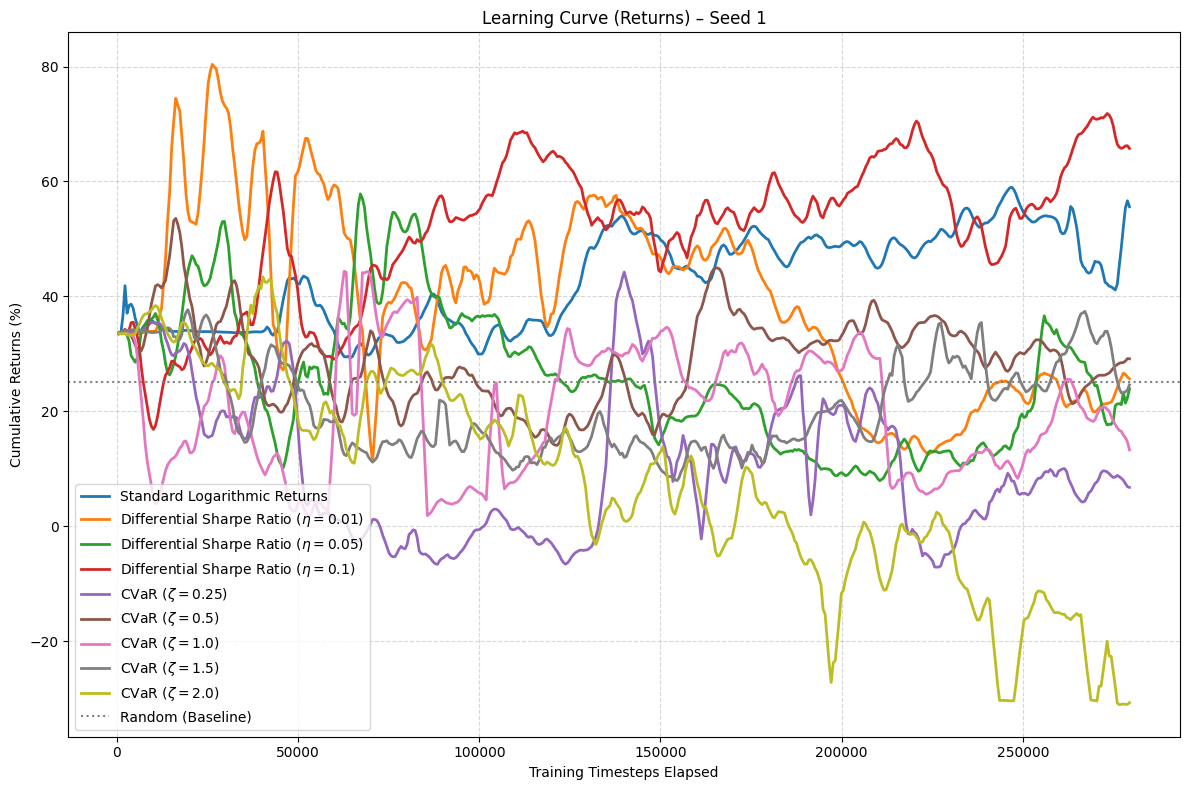

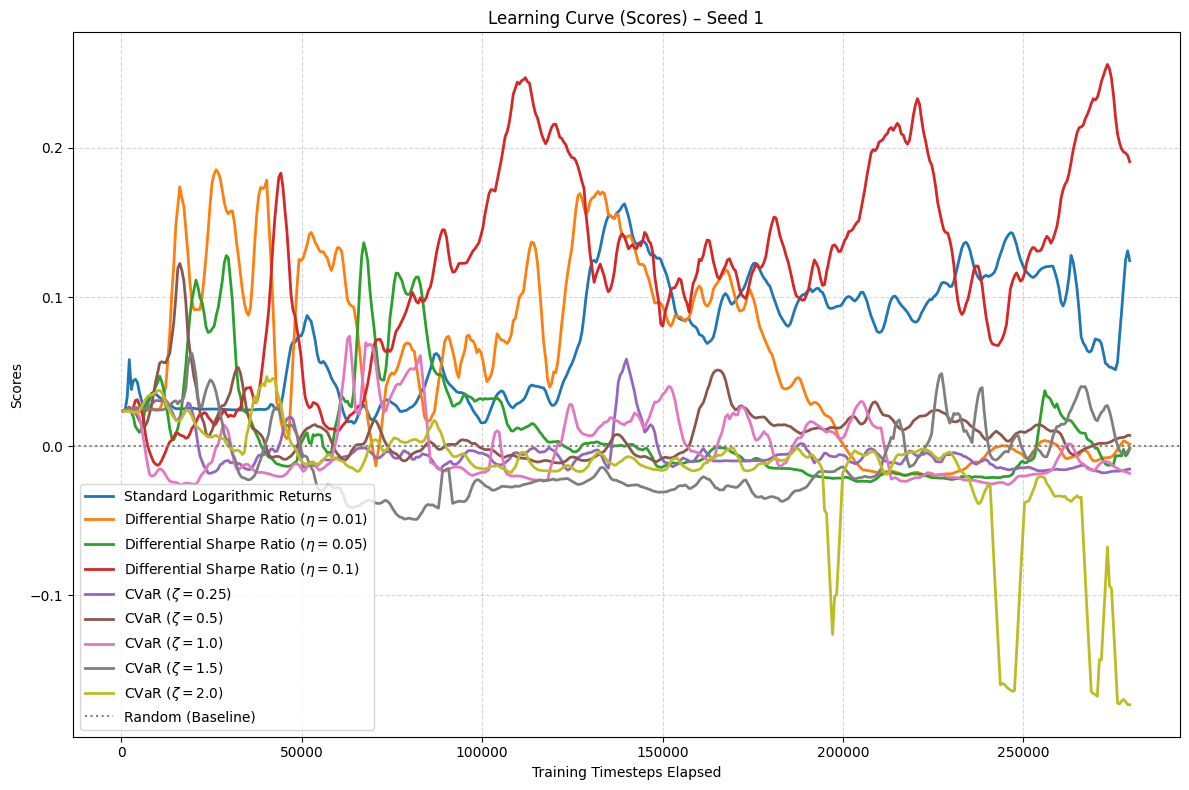

Seed 1: Best Agents and Their Test-Set Performance

Reward Function Cumulative Return Maximum Drawdown Sharpe Ratio Score Training Timesteps Elapsed 
 
 
 Standard Logarithmic Returns 54.683 19.8788 0.113666 0.168772 137200 
 Differential Sharpe Ratio = 0.01 73.2876 26.9254 0.10901 0.194821 39760 
 Differential Sharpe Ratio = 0.05 60.9404 24.2673 0.104974 0.154746 66080 
 Differential Sharpe Ratio = 0.1 72.5139 20.4155 0.114377 0.265259 271600 
 CVaR = 0.25 49.642 27.6569 0.0896994 0.0793799 139440 
 CVaR = 0.5 60.8502 21.2433 0.102432 0.17206 15680 
 CVaR = 1.0 46.0942 22.6627 0.0946977 0.0874462 62720 
 CVaR = 1.5 43.4364 18.8876 0.101419 0.098101 18480 
 CVaR = 2.0 48.7882 30.3269 0.0842029 0.0655848 38080

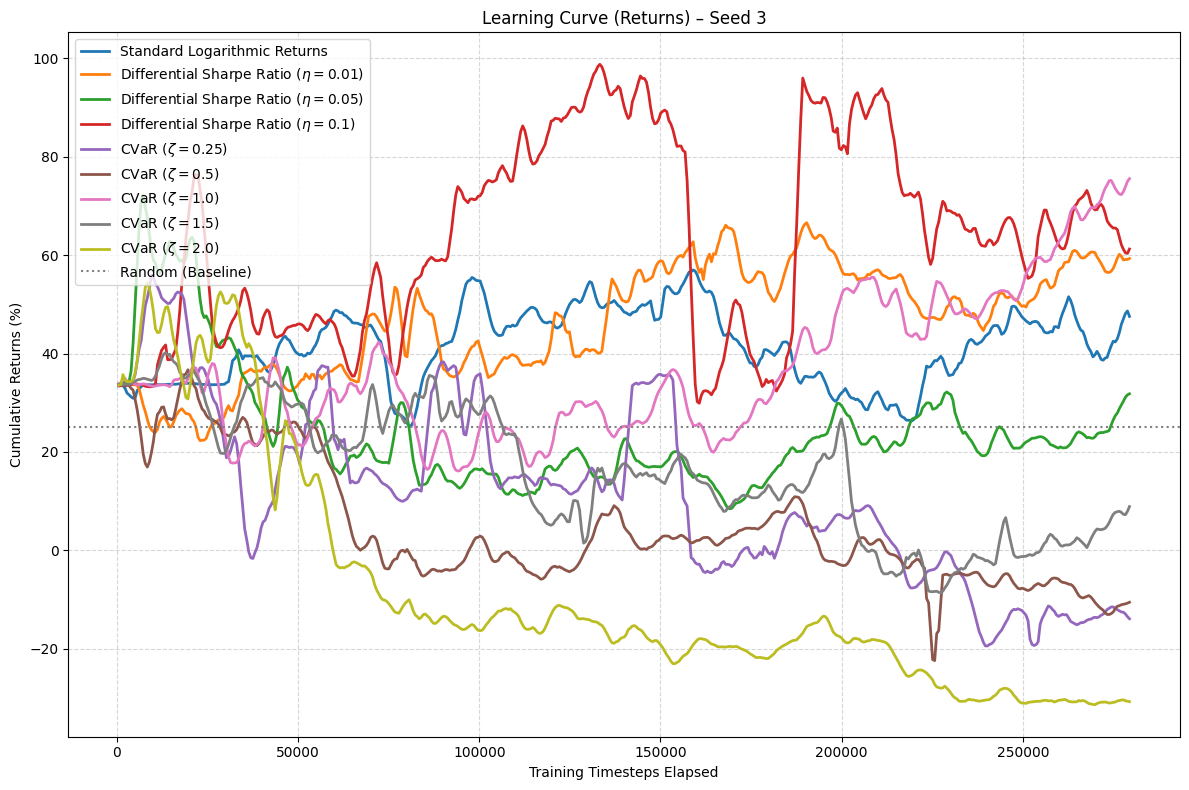

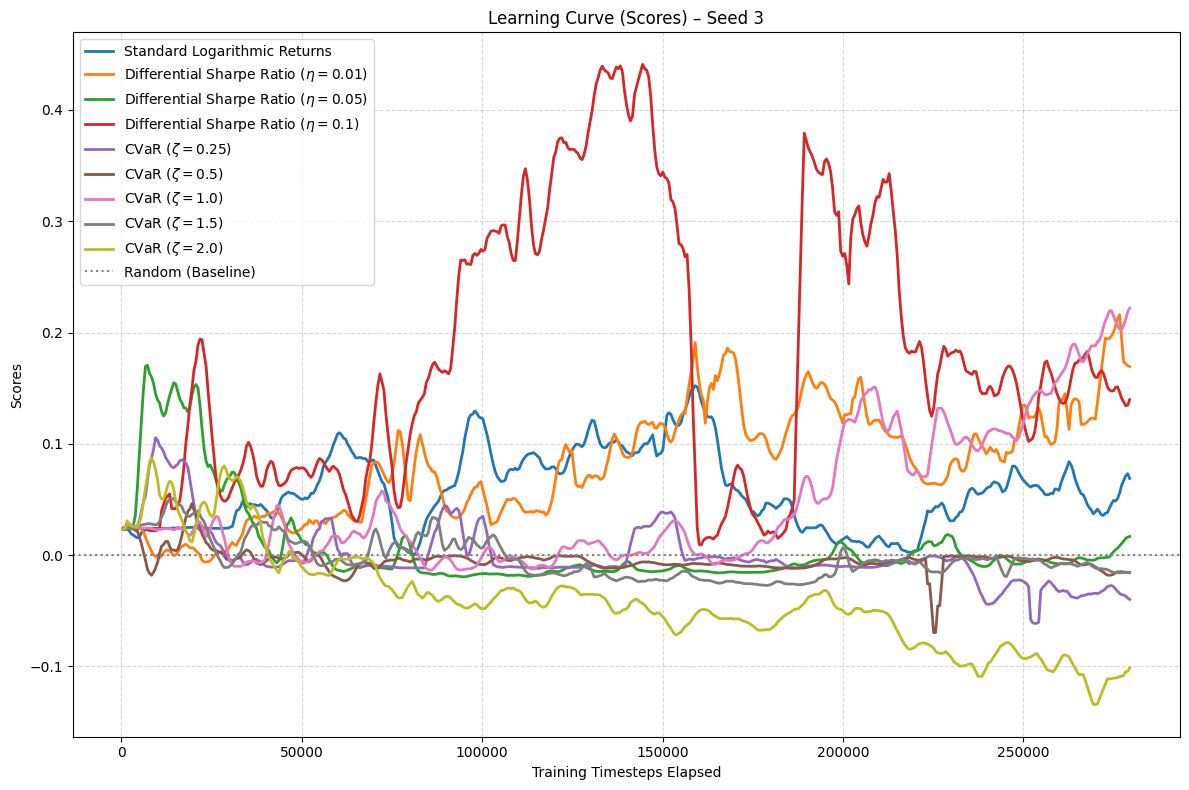

Seed 3: Best Agents and Their Test-Set Performance

Reward Function Cumulative Return Maximum Drawdown Sharpe Ratio Score Training Timesteps Elapsed 
 
 
 Standard Logarithmic Returns 57.7581 21.9913 0.107004 0.158581 157919 
 Differential Sharpe Ratio = 0.01 61.1226 19.4121 0.119398 0.221152 276080 
 Differential Sharpe Ratio = 0.05 69.5724 25.6278 0.1047 0.181415 19600 
 Differential Sharpe Ratio = 0.1 99.972 22.1242 0.138014 0.466646 142240 
 CVaR = 0.25 57.2973 27.3714 0.0966337 0.113435 7840 
 CVaR = 0.5 39.8513 22.2278 0.090359 0.0596942 19600 
 CVaR = 1.0 77.4054 24.7065 0.110206 0.233016 278880 
 CVaR = 1.5 41.4016 23.5841 0.0851057 0.0585845 85680 
 CVaR = 2.0 59.0739 29.4091 0.0942493 0.108664 7840

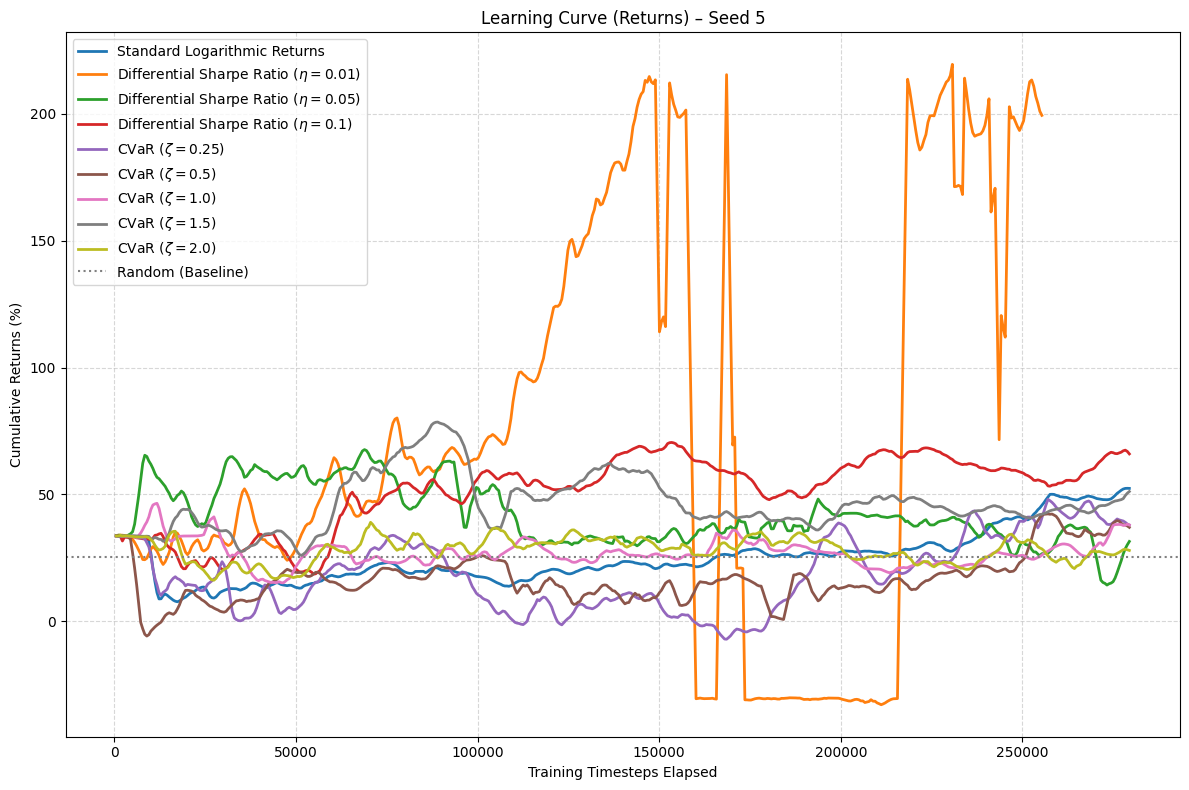

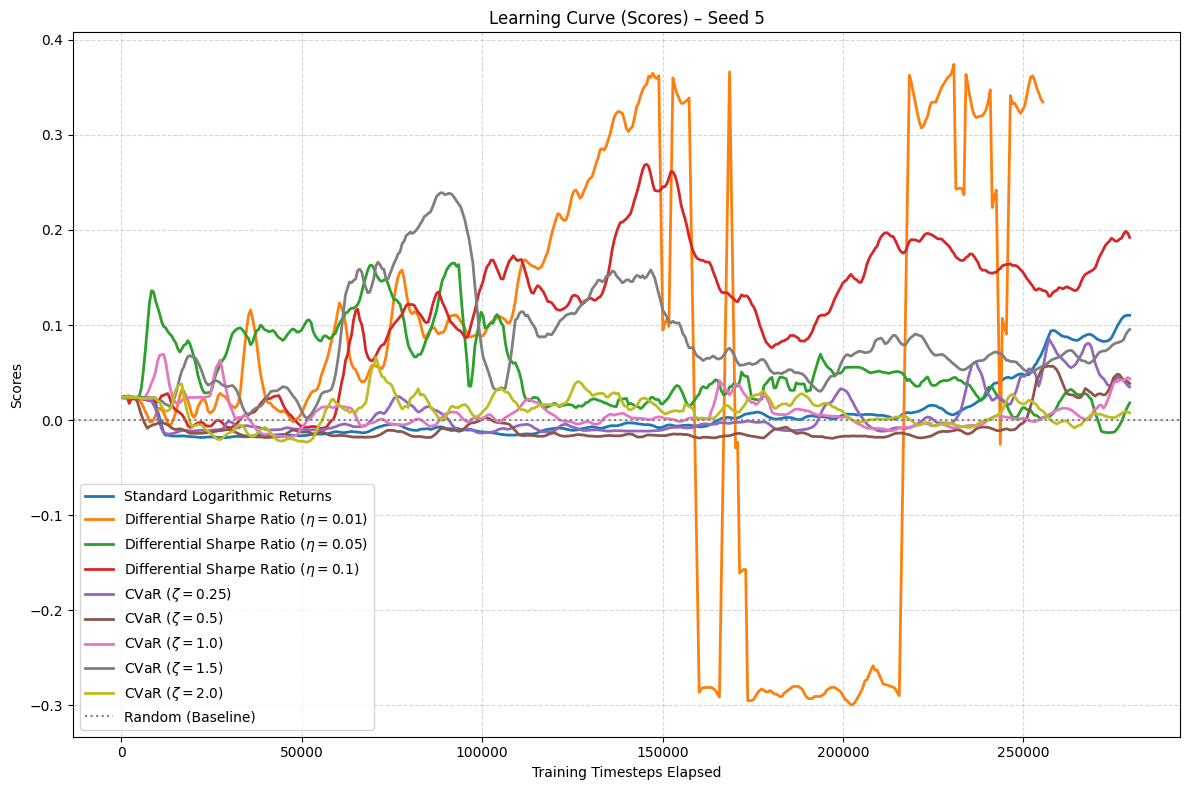

Seed 5: Best Agents and Their Test-Set Performance

Reward Function Cumulative Return Maximum Drawdown Sharpe Ratio Score Training Timesteps Elapsed 
 
 
 Standard Logarithmic Returns 53.0408 24.5251 0.0995809 0.113179 277760 
 Differential Sharpe Ratio = 0.01 227.781 54.6408 0.105248 0.390272 148960 
 Differential Sharpe Ratio = 0.05 65.1467 25.1804 0.113413 0.18007 91280 
 Differential Sharpe Ratio = 0.1 69.5879 18.9561 0.121032 0.283621 144480 
 CVaR = 0.25 50.1113 22.4606 0.0858628 0.0953581 267120 
 CVaR = 0.5 43.9863 23.4474 0.080049 0.0642493 256480 
 CVaR = 1.0 52.8458 26.9624 0.0924965 0.0949547 10080 
 CVaR = 1.5 80.0662 26.2748 0.119879 0.250478 86800 
 CVaR = 2.0 41.7793 18.05 0.0942532 0.0867469 68320

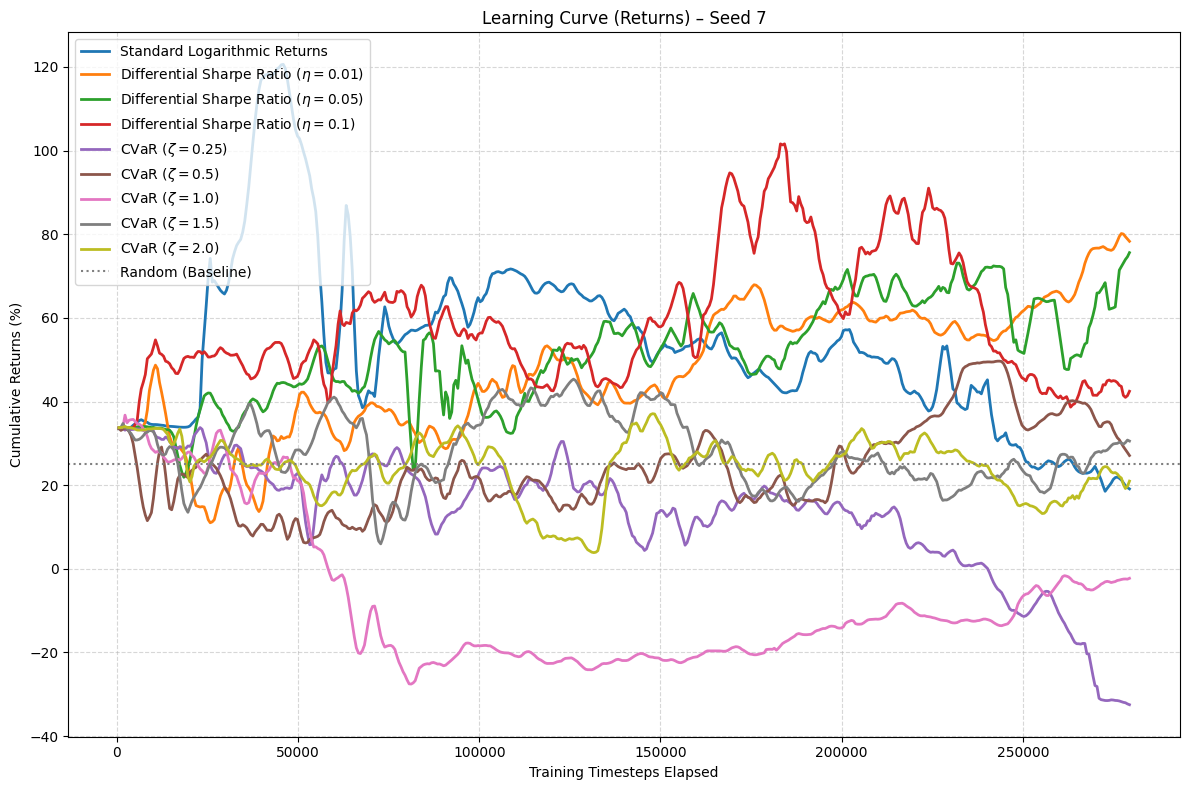

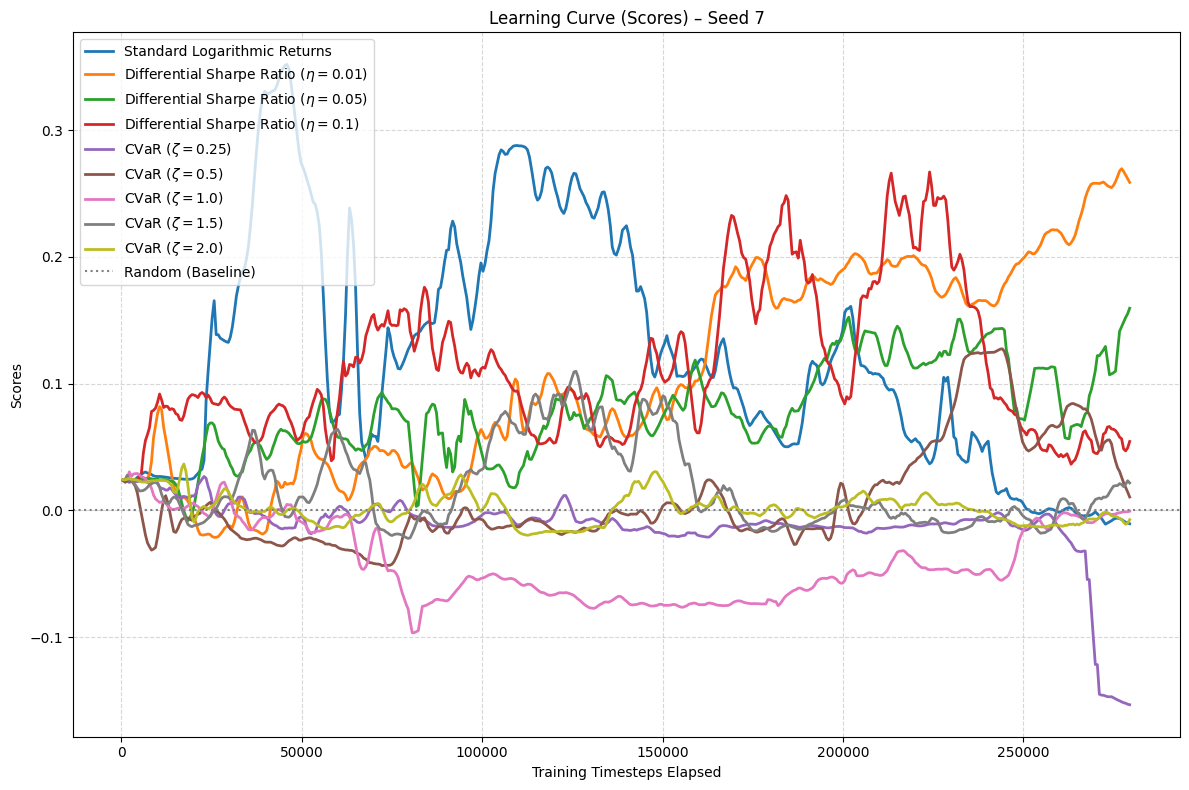

Seed 7: Best Agents and Their Test-Set Performance

Reward Function Cumulative Return Maximum Drawdown Sharpe Ratio Score Training Timesteps Elapsed 
 
 
 Standard Logarithmic Returns 123.082 35.064 0.13173 0.36785 44240 
 Differential Sharpe Ratio = 0.01 82.3104 22.7902 0.11041 0.27684 276640 
 Differential Sharpe Ratio = 0.05 77.1274 30.3513 0.0970863 0.166209 279440 
 Differential Sharpe Ratio = 0.1 99.5687 29.1638 0.125746 0.3208 221760 
 CVaR = 0.25 35.9854 22.6859 0.0783845 0.0373802 21280 
 CVaR = 0.5 49.4507 18.6675 0.0983153 0.127895 244160 
 CVaR = 1.0 36.8046 25.8231 0.0752647 0.0339197 3360 
 CVaR = 1.5 44.8766 17.2894 0.107478 0.122524 119280 
 CVaR = 2.0 37.832 20.7222 0.0907473 0.0554633 16800

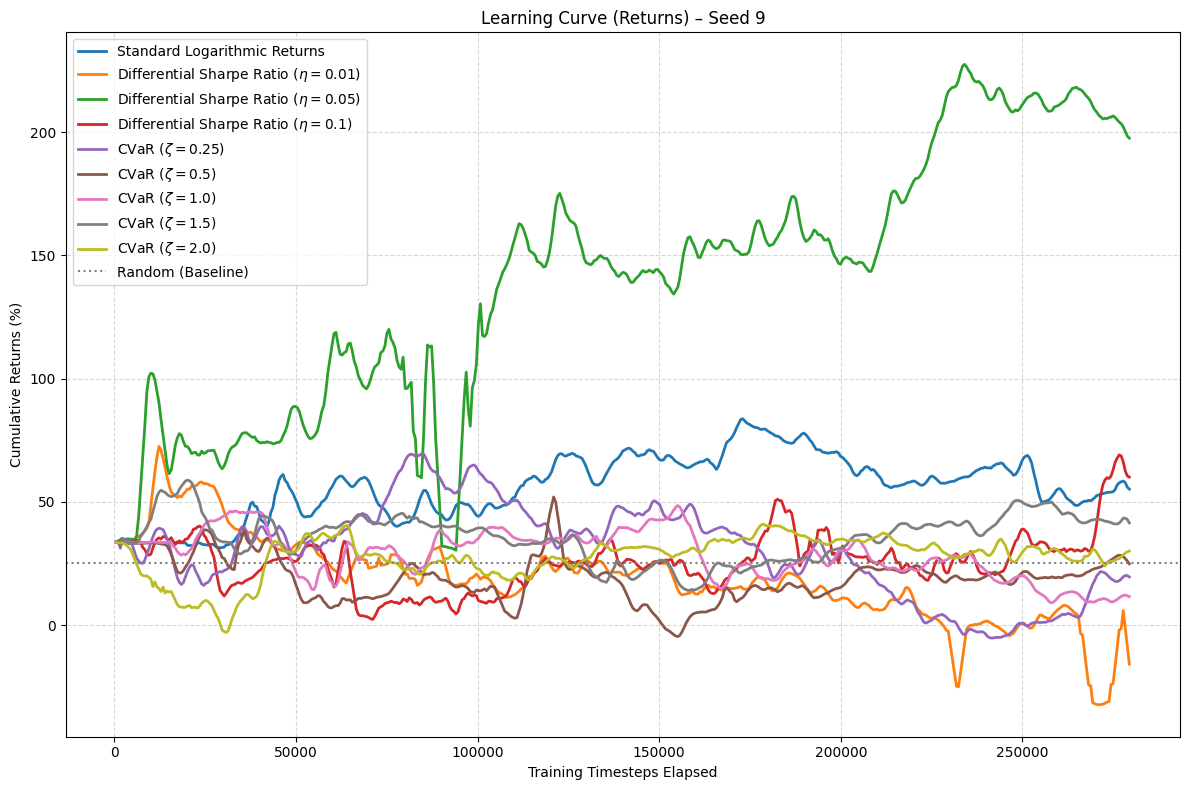

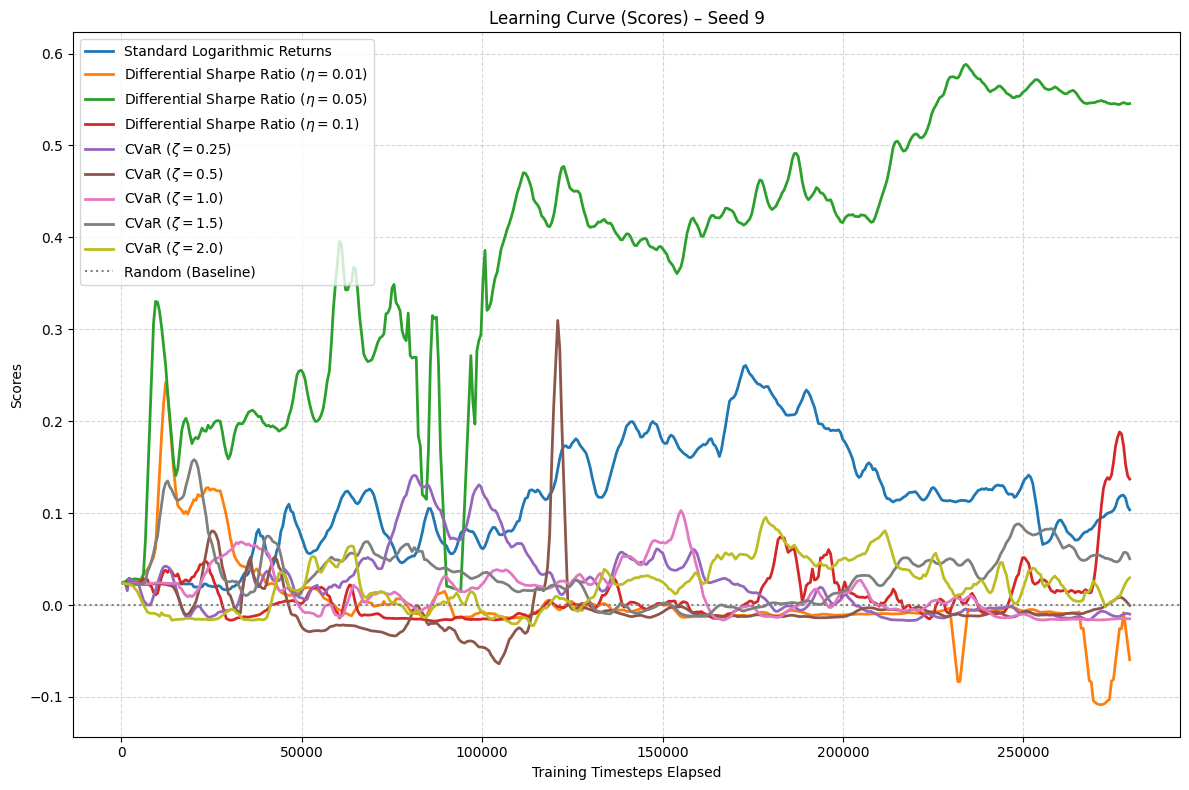

Seed 9: Best Agents and Their Test-Set Performance

Reward Function Cumulative Return Maximum Drawdown Sharpe Ratio Score Training Timesteps Elapsed 
 
 
 Standard Logarithmic Returns 84.1319 25.6187 0.114947 0.264568 170800 
 Differential Sharpe Ratio = 0.01 74.8525 22.5137 0.117923 0.260245 11200 
 Differential Sharpe Ratio = 0.05 186.045 35.9057 0.149758 0.671003 98560 
 Differential Sharpe Ratio = 0.1 75.3934 25.0727 0.112847 0.226058 275520 
 CVaR = 0.25 71.1215 28.8245 0.0931834 0.148562 80080 
 CVaR = 0.5 56.399 10.3736 0.137011 0.412504 119280 
 CVaR = 1.0 49.9472 21.078 0.0949483 0.111626 154560 
 CVaR = 1.5 59.823 21.8789 0.10714 0.169709 19600 
 CVaR = 2.0 42.0931 17.9428 0.10923 0.103042 176400

In [158]:
from itertools import cycle

# A lot of redundancy and repetitions here...
portVals = dict()
FIG_SIZE = (12, 8)
for strat in NON_RL_COMPARISON_STRATEGIES:
    portVals[strat] = evaluateAgent("", "", "", "", "", "", conf=None, save=True, dataType = "testing", forLearningCurve=False, benchmark=False, epoch=0, showTable=False, compare=strat)
    
bestTestSetPerformance = dict()
WINDOW = 5 # raw
VARIED_BASE_SEEDS = [1, 3, 5, 7, 9]


"""
The below code generates more metrics and plots for the test set performance of the agents.
"""
def plotAllCurves(rewardFunctions):
    for seed in VARIED_BASE_SEEDS:
        cumulativeReturnsData = {}
        scoresData = {}
        timeSteps = []

        for rewardFunc in rewardFunctions:
            file = f"portfolios/testing/forLearningCurve{seed}/Reward Function-{rewardFunc}_"
            cumReturns = []
            scores = []
            for i in range(1, LEARNING_CURVE_FILES):
                key = f"{file}{i}.txt"
                values = None
                try:
                    values = np.loadtxt(key)
                except FileNotFoundError:
                    continue
                metrics = scoreFormula(values, avRandReturn)
                cumReturns.append(metrics["Cumulative \nReturn (%)"])
                scores.append(metrics["Score"])
                if len(timeSteps) < LEARNING_CURVE_FILES-1:
                    timeSteps.append(i / LEARNING_CURVE_FILES * SUM_TRAINING_PERIODS)
            cumulativeReturnsData[rewardFunc] = cumReturns
            scoresData[rewardFunc] = scores
            bestPercentThrough = np.argmax(scores)
            bestTestSetPerformance[(rewardFunc, seed)] = [
                max(cumReturns),
                scores[bestPercentThrough],
                int(timeSteps[bestPercentThrough])
            ]
            bestTestSetPerformance[(rewardFunc, seed)].append(np.loadtxt(f"{file}{bestPercentThrough + 1}.txt"))

        # Plot cumulative returns for this seed
        plt.figure(figsize=FIG_SIZE)
        for rewardFunc, cumReturns in cumulativeReturnsData.items():
            properName = rewardFunc.split('_')
            if len(properName) > 1:
                if "CVaR" in properName[0]:
                    plottedName = f"CVaR ($\\zeta={properName[1]}$)"
                elif "Differential Sharpe Ratio" in properName[0]:
                    plottedName = f"Differential Sharpe Ratio ($\\eta={properName[1]}$)"
                else:
                    plottedName = f"{properName[0]} ({properName[1]})"
            else:
                plottedName = properName[0]
            smoothedReturns = np.convolve(cumReturns, np.ones(WINDOW)/WINDOW, mode='valid')
            numTimeSteps = len(np.append(cumReturns[:WINDOW-1], smoothedReturns))
            plt.plot(timeSteps[:numTimeSteps], np.append(cumReturns[:WINDOW-1], smoothedReturns),
                     label=plottedName, linewidth=2)
        plt.axhline(y=avRandReturn*100, color='grey', linestyle=':', label="Random (Baseline)", linewidth=1.5)
        plt.xlabel("Training Timesteps Elapsed")
        plt.ylabel("Cumulative Returns (%)")
        plt.title(f"Learning Curve (Returns) – Seed {seed}")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"plots/Cumulative_Returns_Seed{seed}")
        plt.show()

        # Plot scores for this seed
        plt.figure(figsize=FIG_SIZE)
        for rewardFunc, scores in scoresData.items():
            properName = rewardFunc.split('_')
            if len(properName) > 1:
                if "CVaR" in properName[0]:
                    plottedName = f"CVaR ($\\zeta={properName[1]}$)"
                elif "Differential Sharpe Ratio" in properName[0]:
                    plottedName = f"Differential Sharpe Ratio ($\\eta={properName[1]}$)"
                else:
                    plottedName = f"{properName[0]} ({properName[1]})"
            else:
                plottedName = properName[0]
            smoothedScores = np.convolve(scores, np.ones(WINDOW)/WINDOW, mode='valid')
            numTimeSteps = len(np.append(scores[:WINDOW-1], smoothedScores))
            plt.plot(timeSteps[:numTimeSteps], np.append(scores[:WINDOW-1], smoothedScores),
                     label=plottedName, linewidth=2)
        plt.axhline(y=0, color='grey', linestyle=':', label="Random (Baseline)", linewidth=1.5)
        plt.xlabel("Training Timesteps Elapsed")
        plt.ylabel("Scores")
        plt.title(f"Learning Curve (Scores) – Seed {seed}")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"plots/Scores_Seed{seed}")
        plt.show()

        # Tabulate best agents for this seed
        table = [["Reward Function", "Cumulative Return", "Maximum Drawdown", "Sharpe Ratio", "Score", "Training Timesteps Elapsed"]]
        for rewardFunc in REWARDS["Reward"]:
            properName = rewardFunc.split('_')
            tabulatedName = f"{properName[0] + (f' = {properName[1]}' if len(properName) > 1 else '')}"
            metrics = scoreFormula(bestTestSetPerformance[(rewardFunc, seed)][-1], avRandReturn)
            table.append([
                tabulatedName, 
                metrics["Cumulative \nReturn (%)"], 
                metrics["Maximum \nDrawdown (%)"], 
                metrics["Sharpe Ratio"],
                metrics["Score"], 
                bestTestSetPerformance[(rewardFunc, seed)][2]
            ])
        tabulate_neatly(table, headers="firstrow", title=f"Seed {seed}: Best Agents and Their Test-Set Performance")




plotAllCurves(REWARDS["Reward"])


plt.figure(figsize=(10, 6))
availableColors = ['purple', 'darkgreen', 'darkgray', 'black', 'navy']
colorCycle = cycle(availableColors) 

for seed in VARIED_BASE_SEEDS:
    for rewardFunc in REWARDS["Reward"]:
        properName = rewardFunc.split('_')
        plottedName = f"{properName[0] + (f" = {properName[1]}" if len(properName) > 1 else "")}"
        plt.plot(np.array(bestTestSetPerformance[(rewardFunc, seed)][-1]) / START_CASH * 100 - 100, label=f"{plottedName}")
plt.ylabel("Cumulative Returns (%)")
plt.xlabel("Time")
plt.title("Cumulative Returns On Test Set")

plt.plot(np.array(averPerformance) / START_CASH * 100 - 100, label="Random (Baseline)", color="grey")
for key, value in portVals.items():
    color = next(colorCycle)  
    plt.plot(np.array(value) / START_CASH * 100 - 100, label=key, color=color)

plt.legend()
# plt.savefig("plots/BestRawReturnsAll")
# plt.show()
plt.close()
 
#########################################################################################################


### 5.4 Best Performances and Standard Deviations

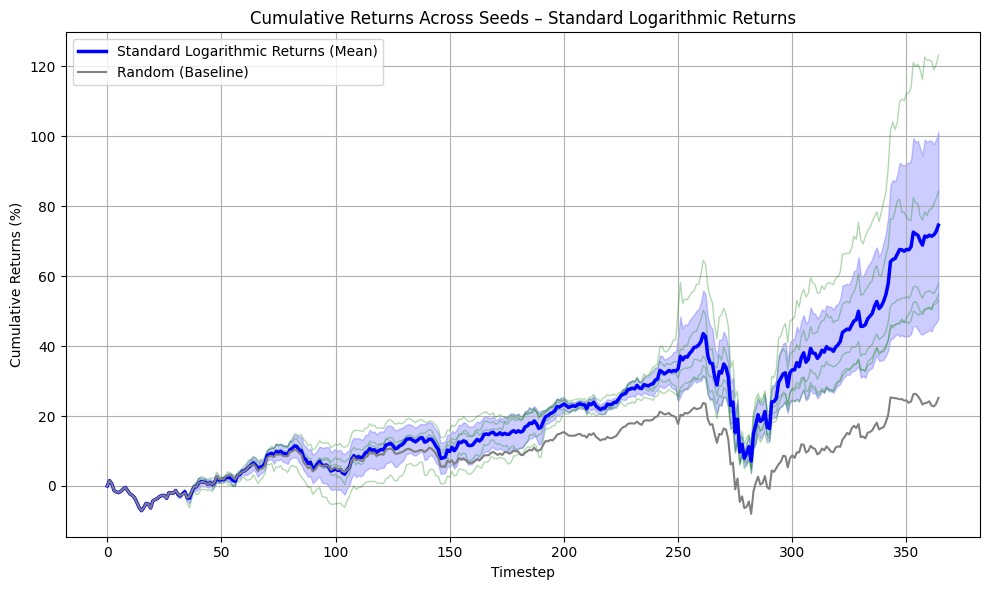

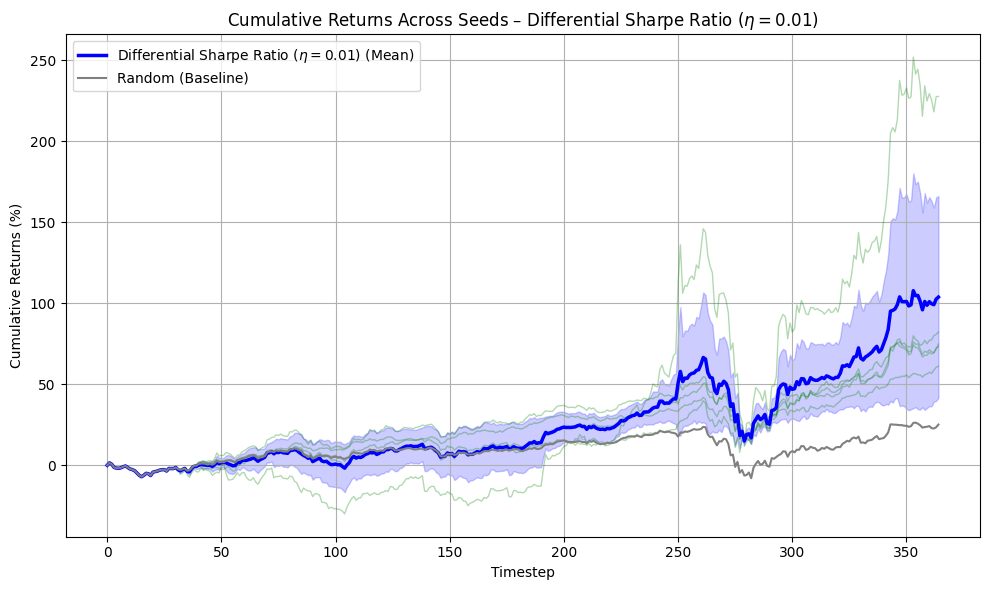

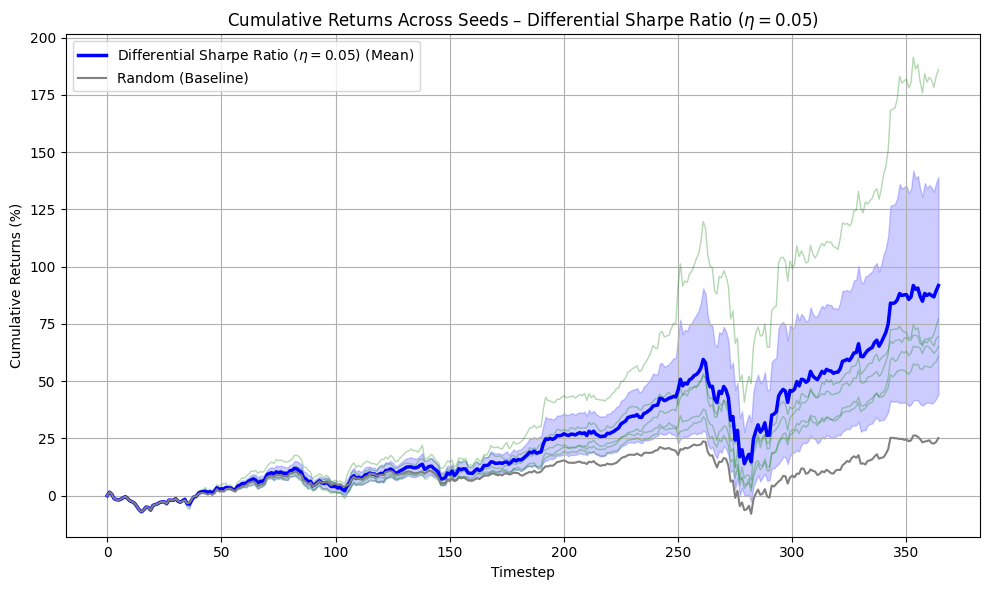

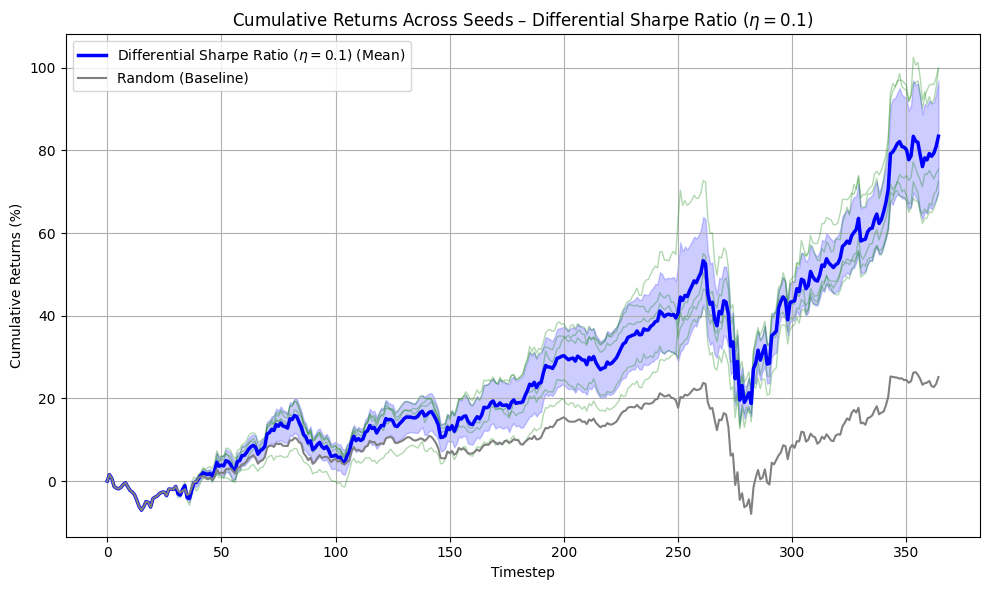

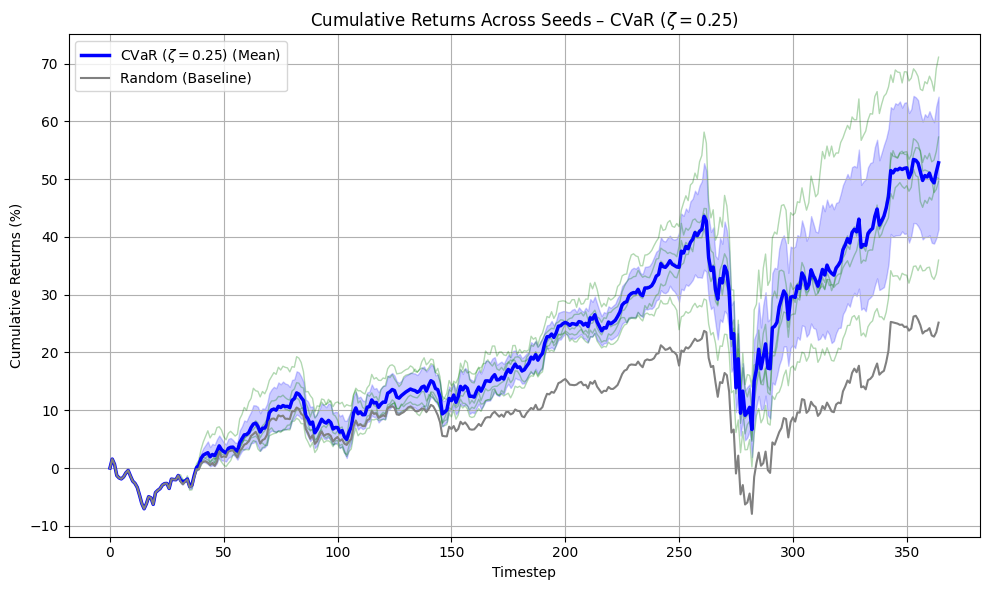

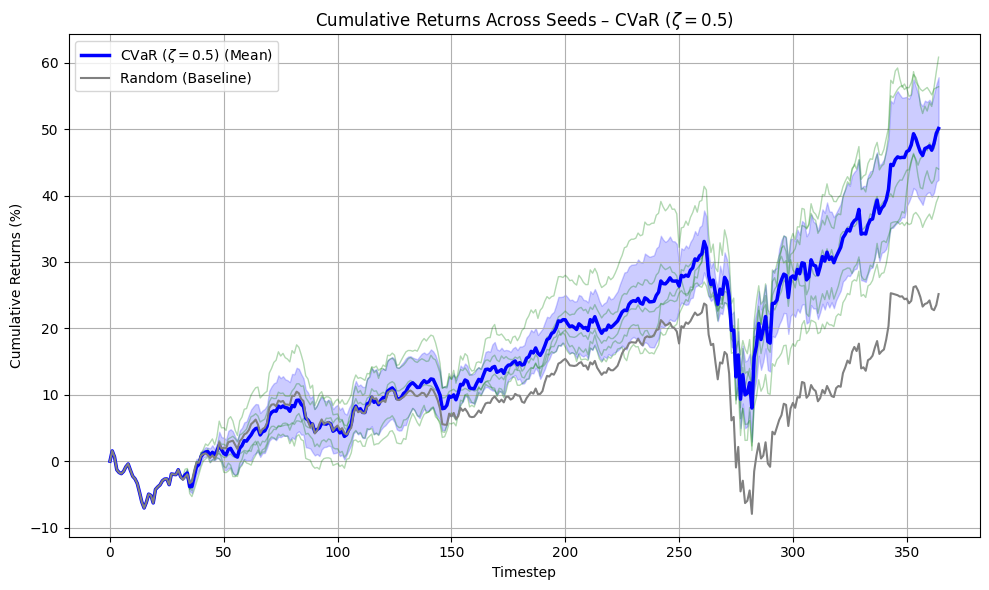

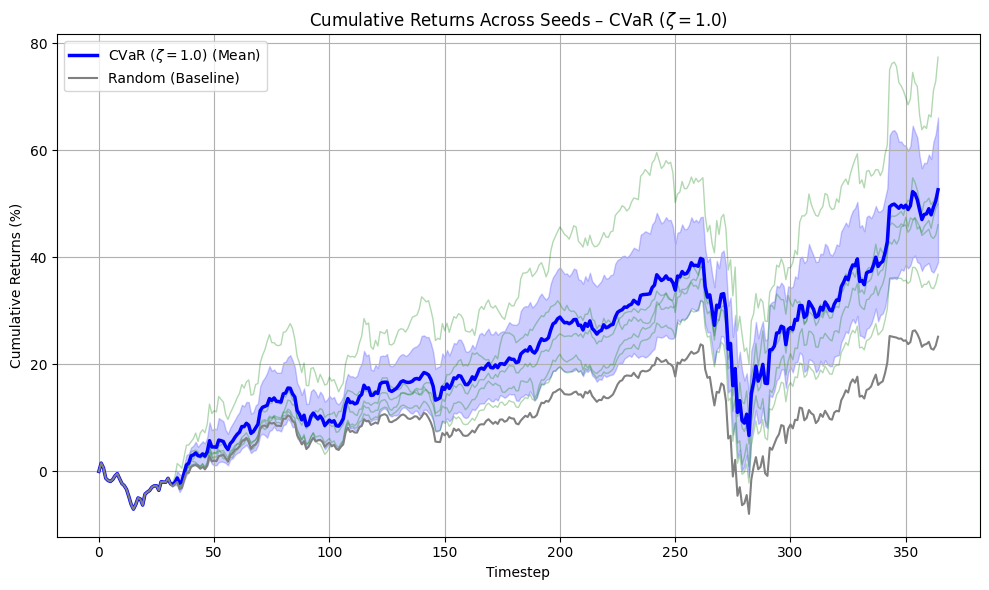

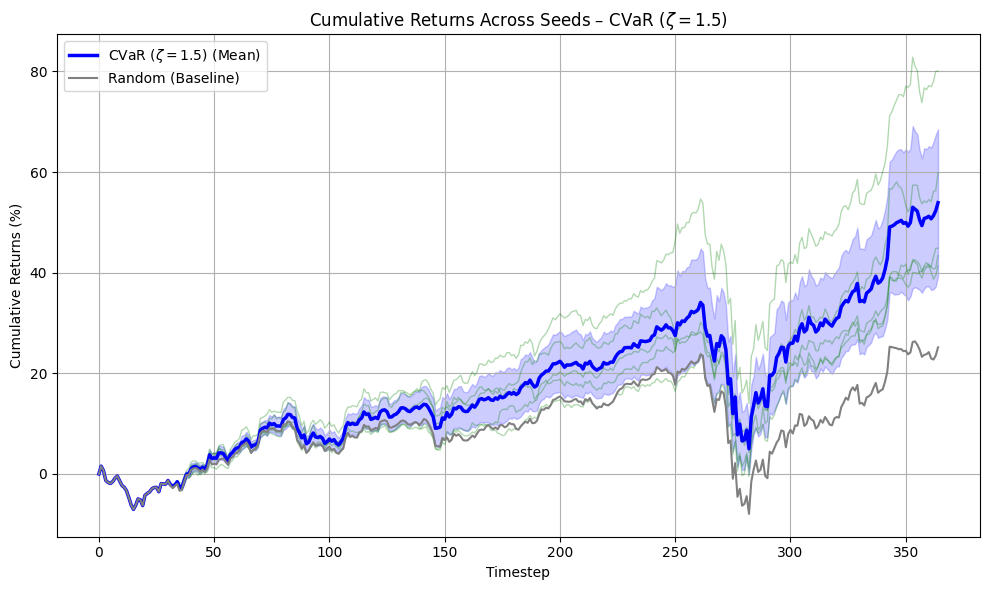

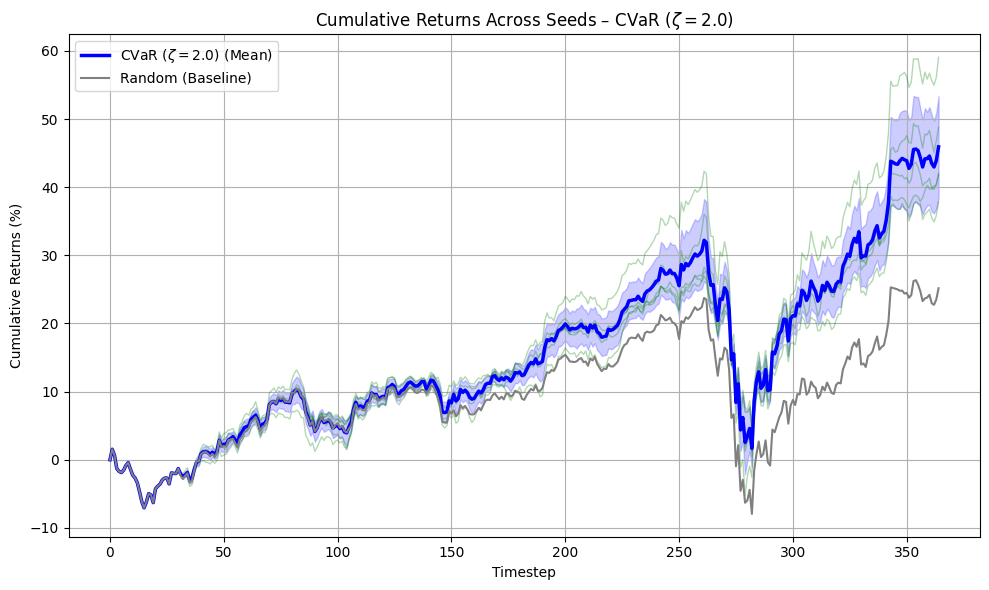

In [159]:

for rewardFunc in REWARDS["Reward"]:
    allTrajectories = []
    for seed in VARIED_BASE_SEEDS:
        traj = np.array(bestTestSetPerformance[(rewardFunc, seed)][-1]) / START_CASH * 100 - 100
        allTrajectories.append(traj)

    # Convert to array for mean/std computation
    allTrajectories = np.array(allTrajectories)
    meanTrajectory = np.mean(allTrajectories, axis=0)
    std_traj = np.std(allTrajectories, axis=0)
    timesteps = np.arange(len(meanTrajectory))

    # Format name for legend and title
    properName = rewardFunc.split('_')
    if len(properName) > 1:
        if "CVaR" in properName[0]:
            plottedName = f"CVaR ($\\zeta={properName[1]}$)"
        elif "Differential Sharpe Ratio" in properName[0]:
            plottedName = f"Differential Sharpe Ratio ($\\eta={properName[1]}$)"
        else:
            plottedName = f"{properName[0]} ({properName[1]})"
    else:
        plottedName = properName[0]

    # Plot
    plt.figure(figsize=(10, 6))
    for traj in allTrajectories:
        plt.plot(timesteps, traj, color='green', alpha=0.3, linewidth=1)  # Faint individual runs
    plt.plot(timesteps, meanTrajectory, color='blue', label=f"{plottedName} (Mean)", linewidth=2.5)
    plt.plot(np.array(averPerformance) / START_CASH * 100 - 100, label="Random (Baseline)", color="grey")
    plt.fill_between(timesteps, meanTrajectory - std_traj, meanTrajectory + std_traj, color='blue', alpha=0.2)
    # Clean filename string: replace space, dot, brackets, equal signs

    safe_filename = rewardFunc.replace(' ', '_').replace('=', '').replace('(', '').replace(')', '').replace('.', '_')

    plt.xlabel("Timestep")
    plt.ylabel("Cumulative Returns (%)")
    plt.title(f"Cumulative Returns Across Seeds – {plottedName}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/Cumulative_Returns_Mean_{safe_filename}")
    plt.show()


### 5.5 Means and Index Comparisons

In [160]:
meanStdPerReward = {}

for rewardFunc in REWARDS["Reward"]:
    allTrajectories = []
    mdds = []
    sharpes = []
    scores = []

    for seed in VARIED_BASE_SEEDS:
        traj = np.array(bestTestSetPerformance[(rewardFunc, seed)][-1])
        normTraj = traj / START_CASH * 100 - 100  # Percentage returns for plotting
        allTrajectories.append(normTraj)

        # Compute MDD and Sharpe on raw values
        raw = traj
        
        mdd = maxDrawdown(raw) * 100  # convert to percent
        returns = np.diff(raw) / raw[:-1]
        sharpe = np.mean(returns) / np.std(returns) if np.std(returns) != 0 else 0

        mdds.append(mdd)
        sharpes.append(sharpe)
        metrs = scoreFormula(traj, avRandReturn)
        scores.append(metrs["Score"])

    allTrajectories = np.array(allTrajectories)
    mean_traj = np.mean(allTrajectories, axis=0)
    std_traj = np.std(allTrajectories, axis=0)

    meanStdPerReward[rewardFunc] = {
        "mean_trajectory": mean_traj,
        "std_trajectory": std_traj,
        "final_mean_return": mean_traj[-1],
        "final_std_dev": np.std([traj[-1] for traj in allTrajectories]),
        "mean_mdd": np.mean(mdds),
        "mean_sharpe": np.mean(sharpes),
        "mean_score": np.mean(scores),
    }

# Optional: print or tabulate results
indexComparisonTable = [["Reward Function", "Final Mean Return (%)", "Std Dev (%)", "Mean MDD (%)", "Mean Sharpe", "Mean Score"]]
for rewardFunc in REWARDS["Reward"]:
    properName = rewardFunc.replace("_", " = ") if "_" in rewardFunc else rewardFunc
    stats = meanStdPerReward[rewardFunc]
    indexComparisonTable.append([
        properName,
        round(stats["final_mean_return"], 4),
        round(stats["final_std_dev"], 4),
        round(stats["mean_mdd"], 4),
        round(stats["mean_sharpe"], 4),
        round(stats["mean_score"], 4)
    ])

tabulate_neatly(indexComparisonTable, headers="firstrow", title="Mean Statistics Across Seeds")



Mean Statistics Across Seeds

Reward Function Final Mean Return (%) Std Dev (%) Mean MDD (%) Mean Sharpe Mean Score 
 
 
 Standard Logarithmic Returns 74.5391 26.7823 25.4156 0.1134 0.2146 
 Differential Sharpe Ratio = 0.01 103.871 62.3274 29.2564 0.1124 0.2687 
 Differential Sharpe Ratio = 0.05 91.7665 47.4431 28.2665 0.114 0.2707 
 Differential Sharpe Ratio = 0.1 83.4072 13.4866 23.1465 0.1224 0.3125 
 CVaR = 0.25 52.8315 11.4528 25.7999 0.0888 0.0948 
 CVaR = 0.5 50.1075 7.7211 19.1919 0.1016 0.1673 
 CVaR = 1.0 52.6195 13.522 24.2465 0.0935 0.1122 
 CVaR = 1.5 53.9208 14.6073 21.583 0.1042 0.1399 
 CVaR = 2.0 45.9133 7.4627 23.2902 0.0945 0.0839

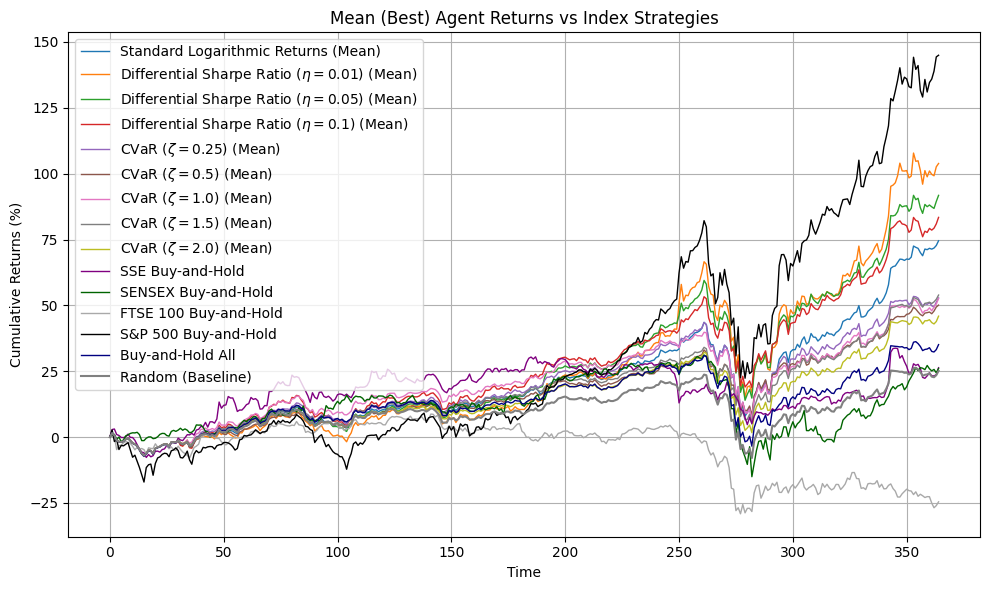

In [161]:
import matplotlib.pyplot as plt
from itertools import cycle

# Define figure and color cycle
plt.figure(figsize=(10, 6))
availableColors = ['purple', 'darkgreen', 'darkgray', 'black', 'navy']
colorCycle = cycle(availableColors)

# Plot mean RL trajectories across seeds
for rewardFunc in REWARDS["Reward"]:
    allTrajectories = []
    for seed in VARIED_BASE_SEEDS:
        traj = np.array(bestTestSetPerformance[(rewardFunc, seed)][-1]) / START_CASH * 100 - 100
        allTrajectories.append(traj)
    meanTrajectory = np.mean(allTrajectories, axis=0)
    timesteps = np.arange(len(meanTrajectory))

    # Format name for legend
    properName = rewardFunc.split('_')
    if len(properName) > 1:
        if "CVaR" in properName[0]:
            plottedName = f"CVaR ($\\zeta={properName[1]}$)"
        elif "Differential Sharpe Ratio" in properName[0]:
            plottedName = f"Differential Sharpe Ratio ($\\eta={properName[1]}$)"
        else:
            plottedName = f"{properName[0]} ({properName[1]})"
    else:
        plottedName = properName[0]

    plt.plot(timesteps, meanTrajectory, label=f"{plottedName} (Mean)", linewidth=1)

# Plot index strategies from portVals with custom dash style
for key, value in portVals.items():
    traj = np.array(value) / START_CASH * 100 - 100
    color = next(colorCycle)
    plt.plot(traj, label=key, color=color, linewidth=1)
plt.plot(np.array(averPerformance) / START_CASH * 100 - 100, label="Random (Baseline)", color="grey")


# Add baseline and labels
plt.xlabel("Time")
plt.ylabel("Cumulative Returns (%)")
plt.title("Mean (Best) Agent Returns vs Index Strategies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/Mean_Returns_vs_Indices")
plt.show()
